In [ ]:
!pip install keras_tuner

Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import json
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import keras_tuner as kt

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

config = {
    'seed': SEED,
    'img_size_small': 128,
    'img_size_large': 224,
    'batch_size': 32,
    'epochs_cnn': 30,
    'epochs_transfer': 20,
    'initial_lr': 0.001,
    'num_classes': 4,
    'class_names': ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'],
    'validation_split': 0.2,
    'test_split': 0.2
}

print("\nConfiguration:")
for key, value in config.items():
    print(f"{key}: {value}")

os.makedirs('saved_models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("\nSetup complete")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1

Configuration:
seed: 42
img_size_small: 128
img_size_large: 224
batch_size: 32
epochs_cnn: 30
epochs_transfer: 20
initial_lr: 0.001
num_classes: 4
class_names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
validation_split: 0.2
test_split: 0.2

Setup complete


In [ ]:
import os
import subprocess
from zipfile import ZipFile

In [ ]:
def download_and_extract_oasis(data_dir="/kaggle/working/", zip_name="imagesoasis.zip"):
    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_path,
        "https://www.kaggle.com/api/v1/datasets/download/ninadaithal/imagesoasis"
    ], check=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(data_dir, "imagesoasis"))

    print(f"Dataset downloaded and extracted to: {os.path.join(data_dir, 'imagesoasis')}")

In [ ]:
download_and_extract_oasis()

Dataset downloaded and extracted to: /kaggle/working/imagesoasis


In [ ]:
data_dir = '/kaggle/working/imagesoasis/Data'

class_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

image_paths = []
labels = []

print("Loading image paths...")

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir, class_name)

    if not os.path.exists(class_folder):
        print(f"Warning: Folder not found - {class_name}")
        continue

    class_images = glob.glob(os.path.join(class_folder, '*.jpg'))
    class_images += glob.glob(os.path.join(class_folder, '*.jpeg'))

    image_paths.extend(class_images)
    labels.extend([class_idx] * len(class_images))

    print(f"{class_name}: {len(class_images)} images")

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total labels: {len(labels)}")
print(f"Classes: {len(class_names)}")

print("\nClass distribution:")
unique, counts = np.unique(labels, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"Class {idx} ({class_names[idx]}): {count} images ({count/len(labels)*100:.2f}%)")

Loading image paths...
Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images
Total labels: 86437
Classes: 4

Class distribution:
Class 0 (Mild Dementia): 5002 images (5.79%)
Class 1 (Moderate Dementia): 488 images (0.56%)
Class 2 (Non Demented): 67222 images (77.77%)
Class 3 (Very mild Dementia): 13725 images (15.88%)


Class Distribution:
Class                     Count      Percentage  
Mild Dementia             5002       5.79        %
Moderate Dementia         488        0.56        %
Non Demented              67222      77.77       %
Very mild Dementia        13725      15.88       %

Total images: 86437
Imbalance ratio: 137.75:1
Most common class: Non Demented (67222 images)
Least common class: Moderate Dementia (488 images)


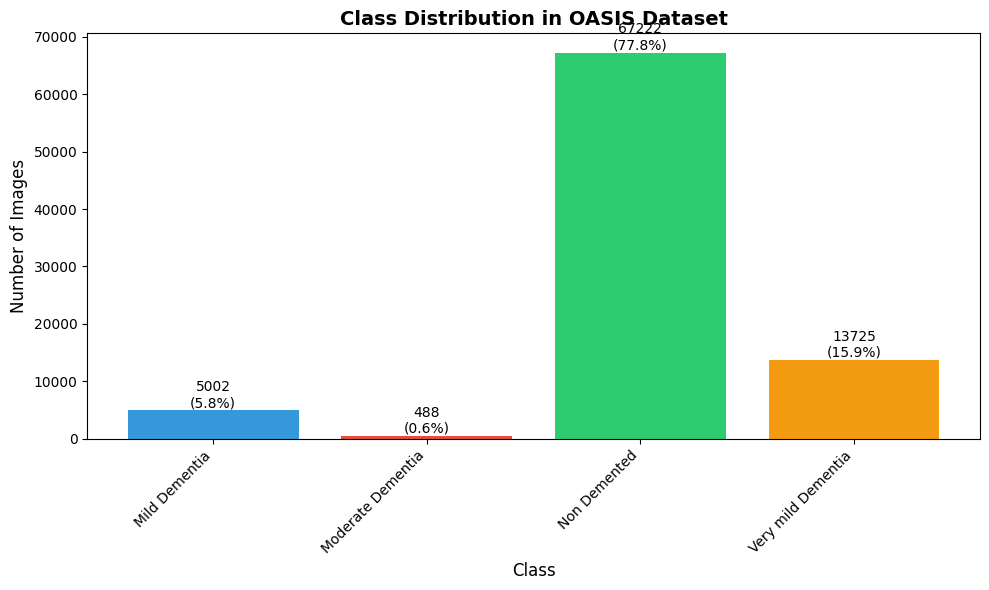


Plot saved: plots/class_distribution.png


In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

total_images = len(labels)
percentages = (label_counts / total_images) * 100

max_count = np.max(label_counts)
min_count = np.min(label_counts)
imbalance_ratio = max_count / min_count

print("Class Distribution:")
print(f"{'Class':<25} {'Count':<10} {'Percentage':<12}")
for idx, count, pct in zip(unique_labels, label_counts, percentages):
    print(f"{class_names[idx]:<25} {count:<10} {pct:<12.2f}%")

print(f"\nTotal images: {total_images}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Most common class: {class_names[np.argmax(label_counts)]} ({max_count} images)")
print(f"Least common class: {class_names[np.argmin(label_counts)]} ({min_count} images)")

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(class_names)), label_counts, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in OASIS Dataset', fontsize=14, fontweight='bold')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')

for i, (bar, count) in enumerate(zip(bars, label_counts)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({percentages[i]:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved: plots/class_distribution.png")

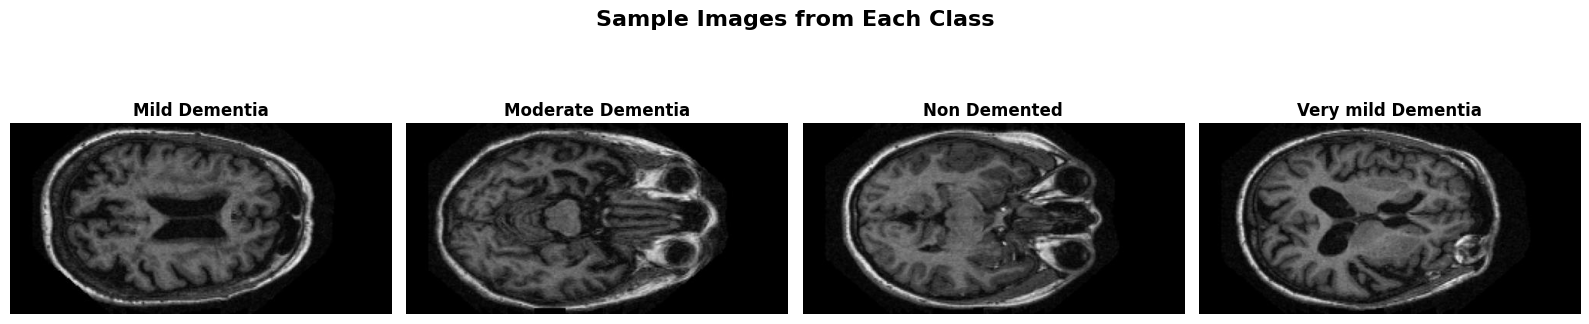

Sample images displayed
Plot saved: plots/sample_images.png

Image properties:
Sample image size: (496, 248)
Sample image mode: RGB


In [ ]:
from PIL import Image

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for class_idx in range(len(class_names)):
    class_mask = labels == class_idx
    class_image_paths = image_paths[class_mask]

    sample_idx = np.random.choice(len(class_image_paths))
    sample_path = class_image_paths[sample_idx]

    img = Image.open(sample_path)
    axes[class_idx].imshow(img, cmap='gray')
    axes[class_idx].axis('off')
    axes[class_idx].set_title(class_names[class_idx], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample images displayed")
print("Plot saved: plots/sample_images.png")

sample_img = Image.open(image_paths[0])
print(f"\nImage properties:")
print(f"Sample image size: {sample_img.size}")
print(f"Sample image mode: {sample_img.mode}")

In [ ]:
print("Analyzing image properties across dataset...")
print("This may take a few minutes...")

image_widths = []
image_heights = []
image_means = []
image_stds = []
image_mins = []
image_maxs = []

sample_size = min(1000, len(image_paths))
sample_indices = np.random.choice(len(image_paths), sample_size, replace=False)
sample_paths = image_paths[sample_indices]

for img_path in sample_paths:
    img = Image.open(img_path)
    img_array = np.array(img)

    height, width = img_array.shape[:2]
    image_widths.append(width)
    image_heights.append(height)

    if len(img_array.shape) == 3:
        img_gray = np.mean(img_array, axis=2)
    else:
        img_gray = img_array

    image_means.append(np.mean(img_gray))
    image_stds.append(np.std(img_gray))
    image_mins.append(np.min(img_gray))
    image_maxs.append(np.max(img_gray))

image_widths = np.array(image_widths)
image_heights = np.array(image_heights)
image_means = np.array(image_means)
image_stds = np.array(image_stds)
image_mins = np.array(image_mins)
image_maxs = np.array(image_maxs)

# Print dimension analysis
print(f"\nImage Dimension Analysis (based on {sample_size} samples):")
print(f"Width - Min: {image_widths.min()}, Max: {image_widths.max()}, Mean: {image_widths.mean():.1f}")
print(f"Height - Min: {image_heights.min()}, Max: {image_heights.max()}, Mean: {image_heights.mean():.1f}")

unique_dims = np.unique(list(zip(image_widths, image_heights)), axis=0)
print(f"Unique dimensions found: {len(unique_dims)}")
print(f"Most common dimension: {image_widths[0]} x {image_heights[0]}")

# Print pixel value statistics
print(f"\nPixel Value Statistics:")
print(f"Mean pixel value - Min: {image_means.min():.2f}, Max: {image_means.max():.2f}, Avg: {image_means.mean():.2f}")
print(f"Std deviation - Min: {image_stds.min():.2f}, Max: {image_stds.max():.2f}, Avg: {image_stds.mean():.2f}")
print(f"Min pixel value - Min: {image_mins.min():.2f}, Max: {image_mins.max():.2f}, Avg: {image_mins.mean():.2f}")
print(f"Max pixel value - Min: {image_maxs.min():.2f}, Max: {image_maxs.max():.2f}, Avg: {image_maxs.mean():.2f}")

# Image quality checks
print(f"\nImage Quality Checks:")

# Check for corrupted images (very low std indicates blank/corrupted)
low_std_threshold = 5.0
low_std_count = np.sum(image_stds < low_std_threshold)
print(f"Images with low std deviation (< {low_std_threshold}): {low_std_count} ({low_std_count/sample_size*100:.2f}%)")

# Check for extreme brightness
very_dark = np.sum(image_means < 50)
very_bright = np.sum(image_means > 200)
print(f"Very dark images (mean < 50): {very_dark} ({very_dark/sample_size*100:.2f}%)")
print(f"Very bright images (mean > 200): {very_bright} ({very_bright/sample_size*100:.2f}%)")

# Overall quality assessment
if low_std_count < sample_size * 0.01 and very_dark < sample_size * 0.05:
    print("\nOverall assessment: Dataset quality is good")
else:
    print("\nOverall assessment: Some quality issues detected, but acceptable for training")

print("\nImage statistics analysis complete")

Analyzing image properties across dataset...
This may take a few minutes...

Image Dimension Analysis (based on 1000 samples):
Width - Min: 496, Max: 496, Mean: 496.0
Height - Min: 248, Max: 248, Mean: 248.0
Unique dimensions found: 1
Most common dimension: 496 x 248

Pixel Value Statistics:
Mean pixel value - Min: 16.71, Max: 68.60, Avg: 42.05
Std deviation - Min: 28.24, Max: 64.92, Avg: 44.92
Min pixel value - Min: 0.00, Max: 0.00, Avg: 0.00
Max pixel value - Min: 228.00, Max: 255.00, Avg: 250.39

Image Quality Checks:
Images with low std deviation (< 5.0): 0 (0.00%)
Very dark images (mean < 50): 891 (89.10%)
Very bright images (mean > 200): 0 (0.00%)

Overall assessment: Some quality issues detected, but acceptable for training

Image statistics analysis complete


/tmp/ipykernel_55/3469118259.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(stats_data,


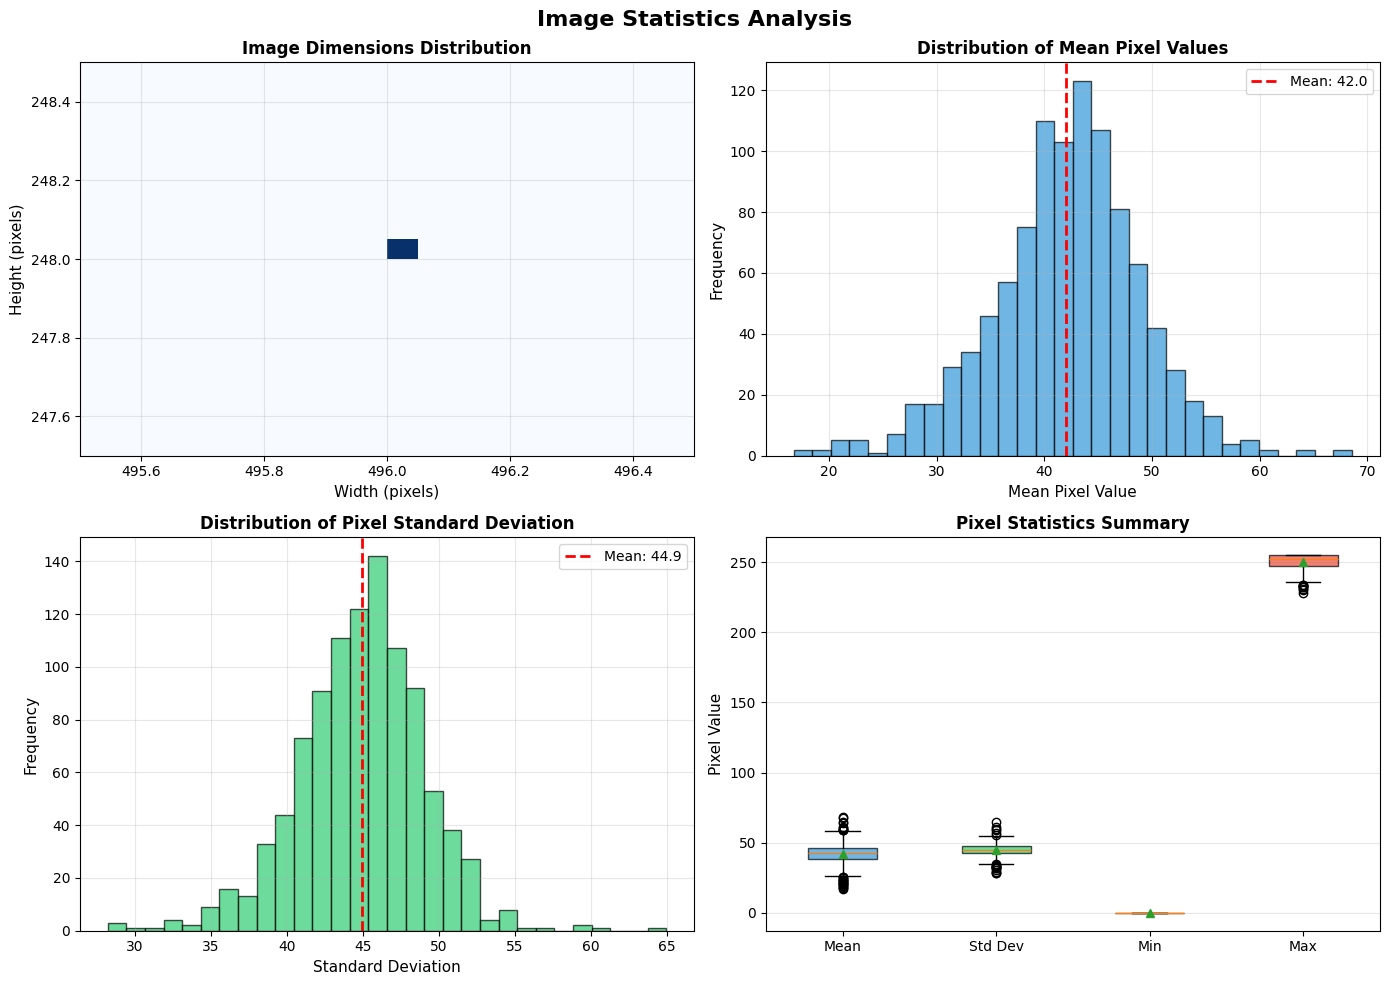

Plot saved: plots/image_statistics.png

Section 5 complete - EDA finished


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Image Statistics Analysis', fontsize=16, fontweight='bold')

# Plot 1: Image dimensions distribution
axes[0, 0].hist2d(image_widths, image_heights, bins=20, cmap='Blues')
axes[0, 0].set_xlabel('Width (pixels)', fontsize=11)
axes[0, 0].set_ylabel('Height (pixels)', fontsize=11)
axes[0, 0].set_title('Image Dimensions Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mean pixel values distribution
axes[0, 1].hist(image_means, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(image_means.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {image_means.mean():.1f}')
axes[0, 1].set_xlabel('Mean Pixel Value', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Mean Pixel Values', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Standard deviation distribution
axes[1, 0].hist(image_stds, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(image_stds.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {image_stds.mean():.1f}')
axes[1, 0].set_xlabel('Standard Deviation', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Pixel Standard Deviation', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Box plot of all statistics
stats_data = [image_means, image_stds, image_mins, image_maxs]
bp = axes[1, 1].boxplot(stats_data,
                         labels=['Mean', 'Std Dev', 'Min', 'Max'],
                         patch_artist=True,
                         showmeans=True)

# Color the boxes
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_ylabel('Pixel Value', fontsize=11)
axes[1, 1].set_title('Pixel Statistics Summary', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('plots/image_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: plots/image_statistics.png")
print("\nSection 5 complete - EDA finished")

In [ ]:
# Split data into train, validation, and test sets
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=SEED,
    stratify=labels
)

# Second split: separate train and validation from remaining 80%
# Validation will be 20% of 80% = 16% of total
# Train will be 80% of 80% = 64% of total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
    random_state=SEED,
    stratify=y_temp
)

# Print split information
print("Data Split Summary:")
print(f"Total images: {len(image_paths)}")
print(f"\nTraining set: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")

# Print class distribution in each split
print("\nClass distribution in splits:")
print(f"{'Class':<25} {'Train':<10} {'Val':<10} {'Test':<10}")

for class_idx in range(len(class_names)):
    train_count = np.sum(y_train == class_idx)
    val_count = np.sum(y_val == class_idx)
    test_count = np.sum(y_test == class_idx)
    print(f"{class_names[class_idx]:<25} {train_count:<10} {val_count:<10} {test_count:<10}")

print("\nStratified split ensures balanced class distribution across all sets")

Data Split Summary:
Total images: 86437

Training set: 51861 images (60.0%)
Validation set: 17288 images (20.0%)
Test set: 17288 images (20.0%)

Class distribution in splits:
Class                     Train      Val        Test      
Mild Dementia             3001       1001       1000      
Moderate Dementia         293        97         98        
Non Demented              40332      13445      13445     
Very mild Dementia        8235       2745       2745      

Stratified split ensures balanced class distribution across all sets


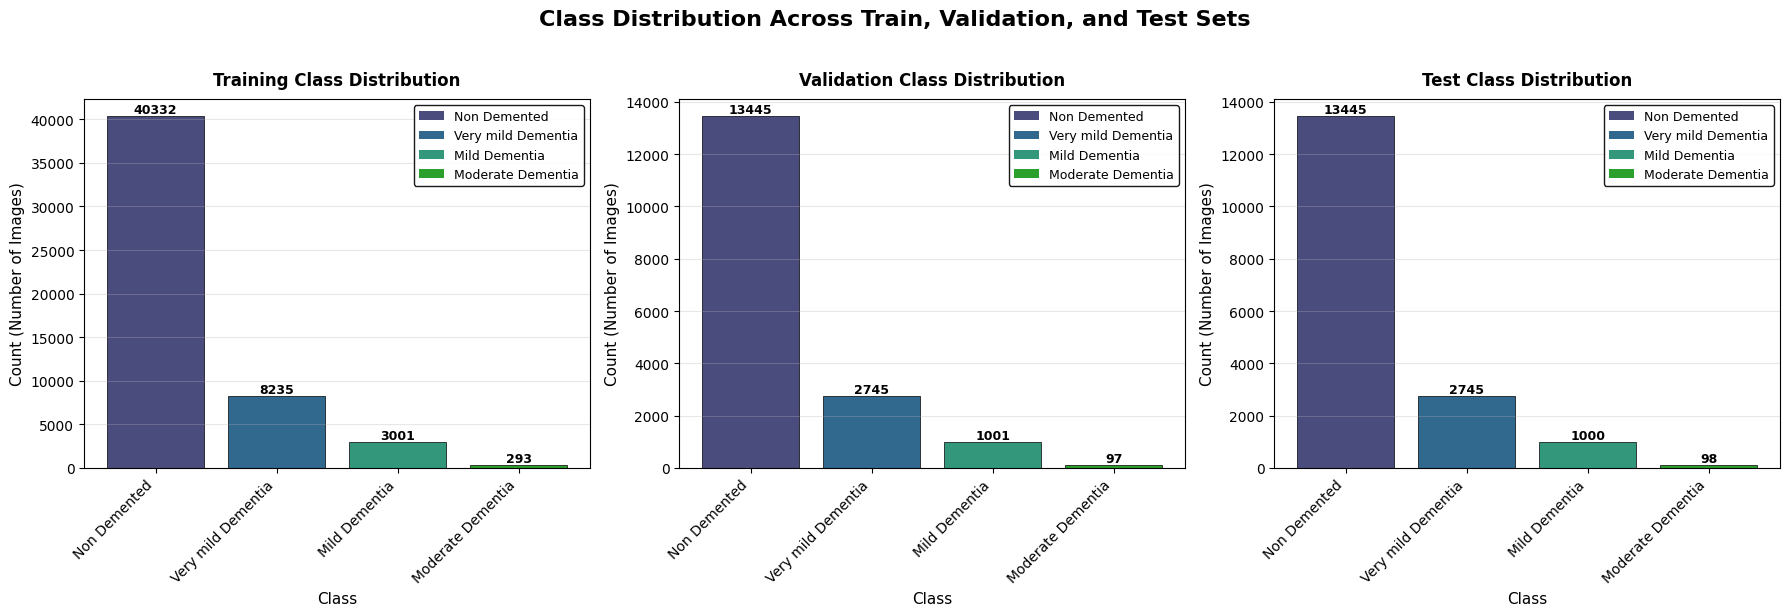

Plot saved: plots/split_distribution.png

Section 6 complete - Data split finished


In [ ]:
# Create visualization of class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Class Distribution Across Train, Validation, and Test Sets',
             fontsize=16, fontweight='bold', y=1.02)

# Define colors (matching the reference image)
colors = ['#33977C', '#2ca02c', '#4B4C7E', '#31688E']

# Data for each split
splits_data = [
    (y_train, X_train, 'Train Class Distribution', 'Training Class Distribution'),
    (y_val, X_val, 'Validation Class Distribution', 'Validation Class Distribution'),
    (y_test, X_test, 'Test Class Distribution', 'Test Class Distribution')
]

for idx, (y_split, X_split, title, subtitle) in enumerate(splits_data):
    # Count classes
    unique, counts = np.unique(y_split, return_counts=True)

    # Create list of (class_name, count, color) and sort by count descending
    class_data = []
    for class_idx, count in zip(unique, counts):
        class_data.append((class_names[class_idx], count, colors[class_idx]))

    # Sort by count (descending)
    class_data.sort(key=lambda x: x[1], reverse=True)

    # Unpack sorted data
    sorted_names = [x[0] for x in class_data]
    sorted_counts = [x[1] for x in class_data]
    sorted_colors = [x[2] for x in class_data]

    # Create bars
    bars = axes[idx].bar(range(len(sorted_names)), sorted_counts, color=sorted_colors, edgecolor='black', linewidth=0.5)

    # Customize plot
    axes[idx].set_xlabel('Class', fontsize=11)
    axes[idx].set_ylabel('Count (Number of Images)', fontsize=11)
    axes[idx].set_title(subtitle, fontsize=12, fontweight='bold', pad=10)
    axes[idx].set_xticks(range(len(sorted_names)))
    axes[idx].set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add count labels on bars
    for bar, count in zip(bars, sorted_counts):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{count}',
                      ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Add legend inside plot at top right
    legend_labels = sorted_names
    legend_handles = [plt.Rectangle((0,0),1,1, fc=color) for color in sorted_colors]
    axes[idx].legend(legend_handles, legend_labels, loc='upper right',
                    fontsize=9, framealpha=0.9, edgecolor='black')

plt.tight_layout()
plt.savefig('plots/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: plots/split_distribution.png")
print("\nSection 6 complete - Data split finished")

In [ ]:
# Compute class weights based on training data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create class weights dictionary
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

# Print class weights
print("Class Weights for Handling Imbalance:")
print(f"{'Class':<25} {'Count':<10} {'Weight':<10}")

for class_idx in range(len(class_names)):
    train_count = np.sum(y_train == class_idx)
    weight = class_weights[class_idx]
    print(f"{class_names[class_idx]:<25} {train_count:<10} {weight:<10.4f}")

print("\nClass weights explanation:")
print("Higher weights are assigned to minority classes")
print("This helps the model pay more attention to underrepresented classes during training")

# Calculate weight ratio
max_weight = max(class_weights.values())
min_weight = min(class_weights.values())
print(f"\nWeight ratio (max/min): {max_weight/min_weight:.2f}:1")

Class Weights for Handling Imbalance:
Class                     Count      Weight    
Mild Dementia             3001       4.3203    
Moderate Dementia         293        44.2500   
Non Demented              40332      0.3215    
Very mild Dementia        8235       1.5744    

Class weights explanation:
Higher weights are assigned to minority classes
This helps the model pay more attention to underrepresented classes during training

Weight ratio (max/min): 137.65:1


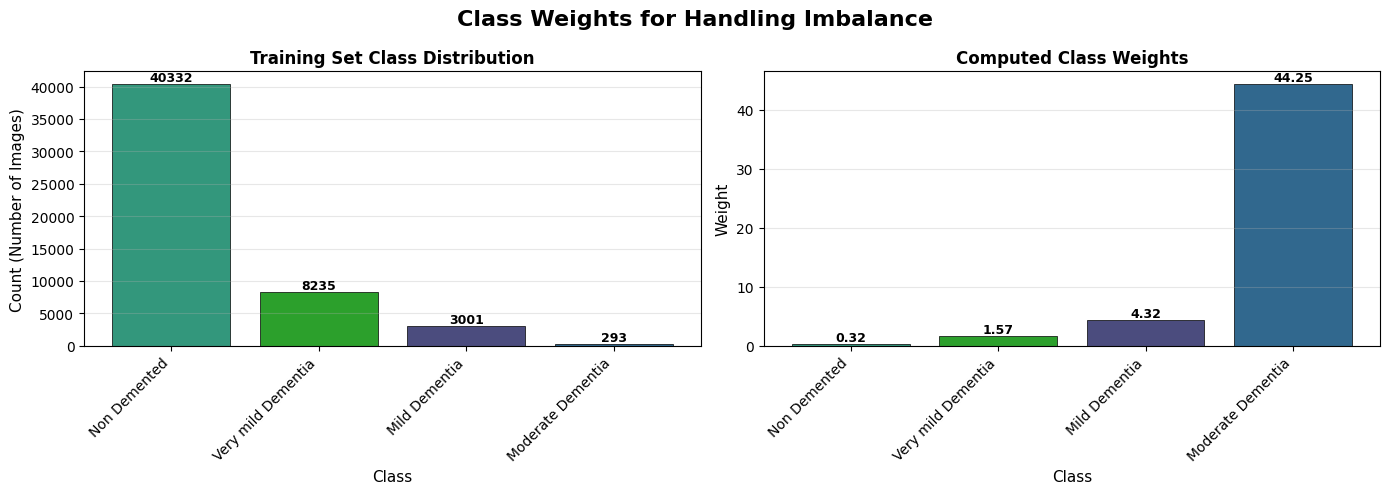

Plot saved: plots/class_weights.png

Section 7 complete - Class weights calculated


In [ ]:
# Create visualization for class weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Class Weights for Handling Imbalance', fontsize=16, fontweight='bold')

# Prepare data - sort by count descending
class_data = []
for class_idx in range(len(class_names)):
    train_count = np.sum(y_train == class_idx)
    weight = class_weights[class_idx]
    class_data.append((class_names[class_idx], train_count, weight))

class_data.sort(key=lambda x: x[1], reverse=True)
sorted_names = [x[0] for x in class_data]
sorted_counts = [x[1] for x in class_data]
sorted_weights = [x[2] for x in class_data]

colors = ['#33977C', '#2ca02c', '#4B4C7E', '#31688E']

# Plot 1: Class counts in training set
bars1 = axes[0].bar(range(len(sorted_names)), sorted_counts, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Class', fontsize=11)
axes[0].set_ylabel('Count (Number of Images)', fontsize=11)
axes[0].set_title('Training Set Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(sorted_names)))
axes[0].set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Add count labels
for bar, count in zip(bars1, sorted_counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Class weights (inverse relationship)
bars2 = axes[1].bar(range(len(sorted_names)), sorted_weights, color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Class', fontsize=11)
axes[1].set_ylabel('Weight', fontsize=11)
axes[1].set_title('Computed Class Weights', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(sorted_names)))
axes[1].set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add weight labels
for bar, weight in zip(bars2, sorted_weights):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{weight:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/class_weights.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: plots/class_weights.png")
print("\nSection 7 complete - Class weights calculated")

Data Augmentation Configuration:
Training augmentation:
  - Rotation: +/- 15 degrees
  - Width shift: +/- 10%
  - Height shift: +/- 10%
  - Horizontal flip: Yes
  - Brightness: 0.8 to 1.2
  - Zoom: +/- 10%
  - Rescale: 1/255

Validation and Test:
  - Rescale only: 1/255
  - No augmentation applied

Generating augmentation examples...


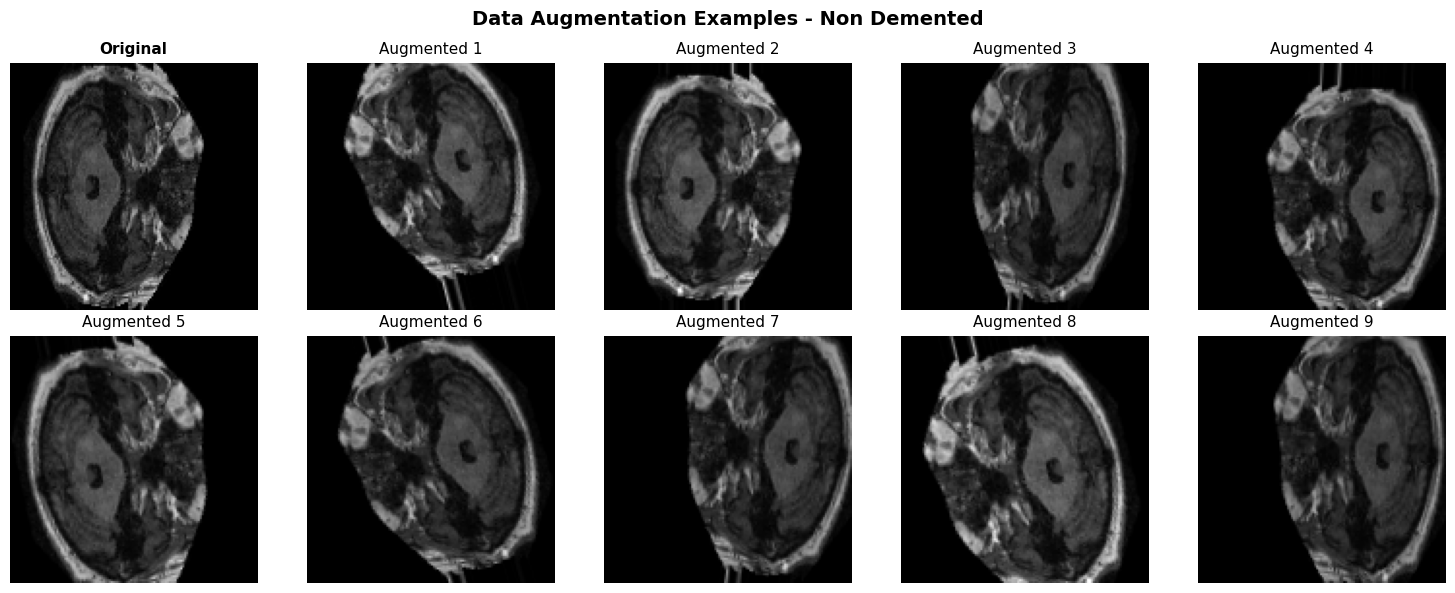

Plot saved: plots/augmentation_examples.png

Section 8 complete - Data augmentation configured


In [ ]:
# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    fill_mode='nearest'
)

# Create ImageDataGenerator for validation and test (no augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Data Augmentation Configuration:")
print("Training augmentation:")
print("  - Rotation: +/- 15 degrees")
print("  - Width shift: +/- 10%")
print("  - Height shift: +/- 10%")
print("  - Horizontal flip: Yes")
print("  - Brightness: 0.8 to 1.2")
print("  - Zoom: +/- 10%")
print("  - Rescale: 1/255")
print("\nValidation and Test:")
print("  - Rescale only: 1/255")
print("  - No augmentation applied")

# Visualize augmentation examples
print("\nGenerating augmentation examples...")

# Select one image from training set
sample_idx = np.random.choice(len(X_train))
sample_image_path = X_train[sample_idx]
sample_label = y_train[sample_idx]

# Load and preprocess the sample image
from tensorflow.keras.preprocessing import image as keras_image

img = keras_image.load_img(sample_image_path, target_size=(128, 128))
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Generate augmented versions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle(f'Data Augmentation Examples - {class_names[sample_label]}',
             fontsize=14, fontweight='bold')

# Original image
axes[0, 0].imshow(img_array[0].astype('uint8'))
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Generate 9 augmented versions
aug_iter = train_datagen.flow(img_array, batch_size=1)

for i in range(9):
    aug_img = next(aug_iter)[0]
    row = (i + 1) // 5
    col = (i + 1) % 5
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i+1}', fontsize=11)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('plots/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: plots/augmentation_examples.png")
print("\nSection 8 complete - Data augmentation configured")

In [ ]:
# TensorFlow dataset pipeline for 128x128 images

IMG_SIZE_SMALL = 128
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_image(path, label, img_size=128, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label

# Create training dataset with augmentation
train_dataset_128 = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset_128 = train_dataset_128.shuffle(buffer_size=1000, seed=SEED)
train_dataset_128 = train_dataset_128.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=128, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset_128 = train_dataset_128.batch(BATCH_SIZE)
train_dataset_128 = train_dataset_128.prefetch(tf.data.AUTOTUNE)

# Create validation dataset without augmentation
val_dataset_128 = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset_128 = val_dataset_128.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=128, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset_128 = val_dataset_128.batch(BATCH_SIZE)
val_dataset_128 = val_dataset_128.prefetch(tf.data.AUTOTUNE)

# Create test dataset without augmentation
test_dataset_128 = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset_128 = test_dataset_128.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=128, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset_128 = test_dataset_128.batch(BATCH_SIZE)
test_dataset_128 = test_dataset_128.prefetch(tf.data.AUTOTUNE)

# Print dataset information
print("TensorFlow Dataset Pipeline (128x128) Created:")
print(f"Image size: {IMG_SIZE_SMALL}x{IMG_SIZE_SMALL}")
print(f"Batch size: {BATCH_SIZE}")
print(f"\nTraining batches: {len(train_dataset_128)}")
print(f"Validation batches: {len(val_dataset_128)}")
print(f"Test batches: {len(test_dataset_128)}")
print("\nTraining dataset: Augmentation enabled")
print("Validation dataset: No augmentation")
print("Test dataset: No augmentation")
print("\nDataset optimizations:")
print("  - Parallel processing: AUTOTUNE")
print("  - Prefetching: AUTOTUNE")
print("  - Shuffling: buffer_size=1000")

TensorFlow Dataset Pipeline (128x128) Created:
Image size: 128x128
Batch size: 32

Training batches: 1621
Validation batches: 541
Test batches: 541

Training dataset: Augmentation enabled
Validation dataset: No augmentation
Test dataset: No augmentation

Dataset optimizations:
  - Parallel processing: AUTOTUNE
  - Prefetching: AUTOTUNE
  - Shuffling: buffer_size=1000


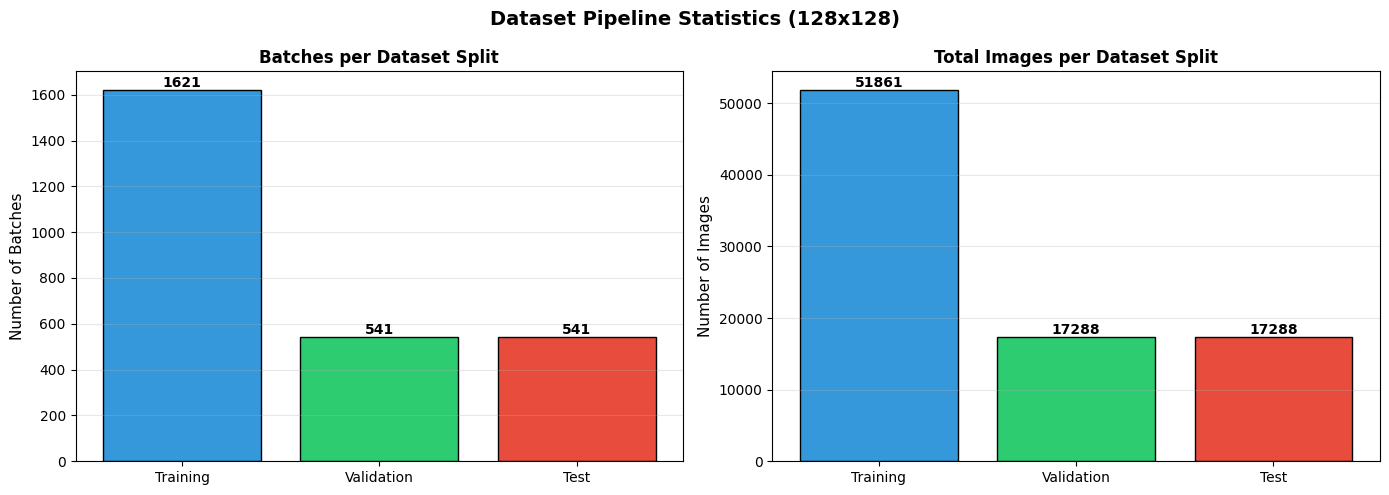

Plots saved:
  - plots/dataset_pipeline_128.png
  - plots/dataset_pipeline_stats_128.png

Section 9 complete - 128x128 dataset pipeline ready


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Dataset Pipeline Statistics (128x128)', fontsize=14, fontweight='bold')

# Plot 1: Number of batches per split
splits = ['Training', 'Validation', 'Test']
batch_counts = [len(train_dataset_128), len(val_dataset_128), len(test_dataset_128)]
colors_splits = ['#3498db', '#2ecc71', '#e74c3c']

bars = axes[0].bar(splits, batch_counts, color=colors_splits, edgecolor='black', linewidth=1)
axes[0].set_ylabel('Number of Batches', fontsize=11)
axes[0].set_title('Batches per Dataset Split', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, batch_counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Images per split
image_counts = [len(X_train), len(X_val), len(X_test)]
bars2 = axes[1].bar(splits, image_counts, color=colors_splits, edgecolor='black', linewidth=1)
axes[1].set_ylabel('Number of Images', fontsize=11)
axes[1].set_title('Total Images per Dataset Split', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars2, image_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/dataset_pipeline_stats_128.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved:")
print("  - plots/dataset_pipeline_128.png")
print("  - plots/dataset_pipeline_stats_128.png")
print("\nSection 9 complete - 128x128 dataset pipeline ready")

In [ ]:
# TensorFlow dataset pipeline for 224x224 images
# This will be used for Custom CNN and transfer learning models

IMG_SIZE_LARGE = 224

# Create training dataset with augmentation for 224x224
train_dataset_224 = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset_224 = train_dataset_224.shuffle(buffer_size=1000, seed=SEED)
train_dataset_224 = train_dataset_224.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=224, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset_224 = train_dataset_224.batch(BATCH_SIZE)
train_dataset_224 = train_dataset_224.prefetch(tf.data.AUTOTUNE)

# Create validation dataset without augmentation for 224x224
val_dataset_224 = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset_224 = val_dataset_224.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=224, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset_224 = val_dataset_224.batch(BATCH_SIZE)
val_dataset_224 = val_dataset_224.prefetch(tf.data.AUTOTUNE)

# Create test dataset without augmentation for 224x224
test_dataset_224 = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset_224 = test_dataset_224.map(
    lambda x, y: load_and_preprocess_image(x, y, img_size=224, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset_224 = test_dataset_224.batch(BATCH_SIZE)
test_dataset_224 = test_dataset_224.prefetch(tf.data.AUTOTUNE)

# Print dataset information
print("TensorFlow Dataset Pipeline (224x224) Created:")
print(f"Image size: {IMG_SIZE_LARGE}x{IMG_SIZE_LARGE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"\nTraining batches: {len(train_dataset_224)}")
print(f"Validation batches: {len(val_dataset_224)}")
print(f"Test batches: {len(test_dataset_224)}")
print("\nTraining dataset: Augmentation enabled")
print("Validation dataset: No augmentation")
print("Test dataset: No augmentation")
print("\nDataset optimizations:")
print("  - Parallel processing: AUTOTUNE")
print("  - Prefetching: AUTOTUNE")
print("  - Shuffling: buffer_size=1000")

# Compare 128x128 vs 224x224 pipelines
print("\nPipeline Comparison:")
print(f"{'Pipeline':<15} {'Image Size':<15} {'Train Batches':<15} {'Val Batches':<15} {'Test Batches':<15}")
print(f"{'128x128':<15} {'128x128':<15} {len(train_dataset_128):<15} {len(val_dataset_128):<15} {len(test_dataset_128):<15}")
print(f"{'224x224':<15} {'224x224':<15} {len(train_dataset_224):<15} {len(val_dataset_224):<15} {len(test_dataset_224):<15}")

print("\nBoth pipelines ready for training")
print("Section 10 complete - All data preprocessing finished")

TensorFlow Dataset Pipeline (224x224) Created:
Image size: 224x224
Batch size: 32

Training batches: 1621
Validation batches: 541
Test batches: 541

Training dataset: Augmentation enabled
Validation dataset: No augmentation
Test dataset: No augmentation

Dataset optimizations:
  - Parallel processing: AUTOTUNE
  - Prefetching: AUTOTUNE
  - Shuffling: buffer_size=1000

Pipeline Comparison:
Pipeline        Image Size      Train Batches   Val Batches     Test Batches   
128x128         128x128         1621            541             541            
224x224         224x224         1621            541             541            

Both pipelines ready for training
Section 10 complete - All data preprocessing finished


In [ ]:
def create_simple_baseline_cnn(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model

simple_cnn = create_simple_baseline_cnn(input_shape=(128, 128, 3), num_classes=4)

simple_cnn.compile(
    optimizer=Adam(learning_rate=0.01),  # Higher than optimal
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
print("Simple Baseline CNN Architecture:")

simple_cnn.summary()

Simple Baseline CNN Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,564 (8.02 MB)

 Trainable params: 2,102,564 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

Evaluating Simple CNN with random weights (before training)...
This shows the baseline performance with untrained model



I0000 00:00:1766935470.534564     134 service.cc:152] XLA service 0x7fdb880024d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766935470.534603     134 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766935470.534608     134 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766935470.669437     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


 19/541 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5955 - loss: 1.3464

I0000 00:00:1766935472.087431     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


541/541 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5681 - loss: 1.3493

Simple CNN - Pre-Training Evaluation:
  Test Loss (untrained): 1.3499
  Test Accuracy (untrained): 0.5602 (56.02%)
  Precision (untrained): 0.6341
  Recall (untrained): 0.5602
  F1-Score (untrained): 0.5812


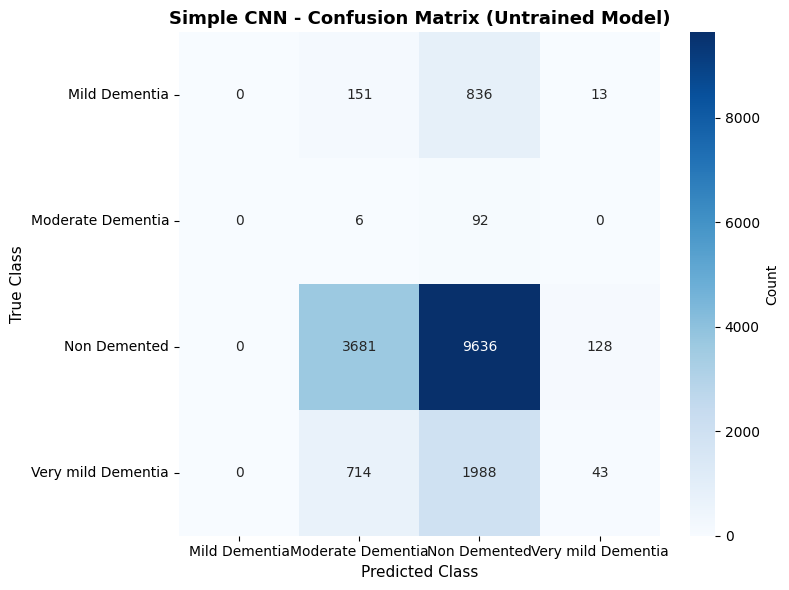


Pre-training evaluation complete


In [ ]:
print("Evaluating Simple CNN with random weights (before training)...")
print("This shows the baseline performance with untrained model")
print()

test_loss_untrained, test_acc_untrained = simple_cnn.evaluate(
    test_dataset_128,
    verbose=1
)

print()
print("Simple CNN - Pre-Training Evaluation:")
print(f"  Test Loss (untrained): {test_loss_untrained:.4f}")
print(f"  Test Accuracy (untrained): {test_acc_untrained:.4f} ({test_acc_untrained*100:.2f}%)")

y_pred_untrained = simple_cnn.predict(test_dataset_128, verbose=0)
y_pred_classes_untrained = np.argmax(y_pred_untrained, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

precision_untrained = precision_score(y_test, y_pred_classes_untrained, average='weighted', zero_division=0)
recall_untrained = recall_score(y_test, y_pred_classes_untrained, average='weighted', zero_division=0)
f1_untrained = f1_score(y_test, y_pred_classes_untrained, average='weighted', zero_division=0)

print(f"  Precision (untrained): {precision_untrained:.4f}")
print(f"  Recall (untrained): {recall_untrained:.4f}")
print(f"  F1-Score (untrained): {f1_untrained:.4f}")

cm_untrained = confusion_matrix(y_test, y_pred_classes_untrained)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_untrained, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=11)
plt.ylabel('True Class', fontsize=11)
plt.title('Simple CNN - Confusion Matrix (Untrained Model)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/simple_cnn_pretrain_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

simple_cnn_pretrain_results = {
    'model_name': 'Simple CNN',
    'accuracy': test_acc_untrained,
    'precision': precision_untrained,
    'recall': recall_untrained,
    'f1_score': f1_untrained,
    'loss': test_loss_untrained
}

print("\nPre-training evaluation complete")

In [ ]:
print("Training Simple CNN")
print()

# Rebuild model with standard learning rate
simple_cnn = create_simple_baseline_cnn(input_shape=(128, 128, 3), num_classes=4)

simple_cnn.compile(
    optimizer=Adam(learning_rate=0.00001),  # Standard learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks_simple = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'saved_models/simple_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train the model
history_simple = simple_cnn.fit(
    train_dataset_128,
    validation_data=val_dataset_128,
    epochs=30,
    callbacks=callbacks_simple,
    class_weight=class_weights,
    verbose=1
)

print("\nTraining complete")

Training Simple CNN

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-28 15:24:59.370108: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 15:24:59.508811: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1620/1621 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4709 - loss: 1.3581

2025-12-28 15:25:21.046899: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 15:25:21.185598: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1621/1621 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.4709 - loss: 1.3580 - val_accuracy: 0.6930 - val_loss: 1.0107 - learning_rate: 1.0000e-05
Epoch 2/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5700 - loss: 1.1346 - val_accuracy: 0.6133 - val_loss: 0.9617 - learning_rate: 1.0000e-05
Epoch 3/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6182 - loss: 0.9015 - val_accuracy: 0.6408 - val_loss: 0.8921 - learning_rate: 1.0000e-05
Epoch 4/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.6566 - loss: 0.7658 - val_accuracy: 0.7266 - val_loss: 0.7059 - learning_rate: 1.0000e-05
Epoch 5/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6845 - loss: 0.6731 - val_accuracy: 0.7551 - val_loss: 0.6275 - learning_rate: 1.0000e-05
Epoch 6/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7042 - loss: 0.6006 - val_accuracy: 0.7884 - val_loss: 0.5519 - learning_rate: 1.0000e-05
Epoch 7/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/


Training complete


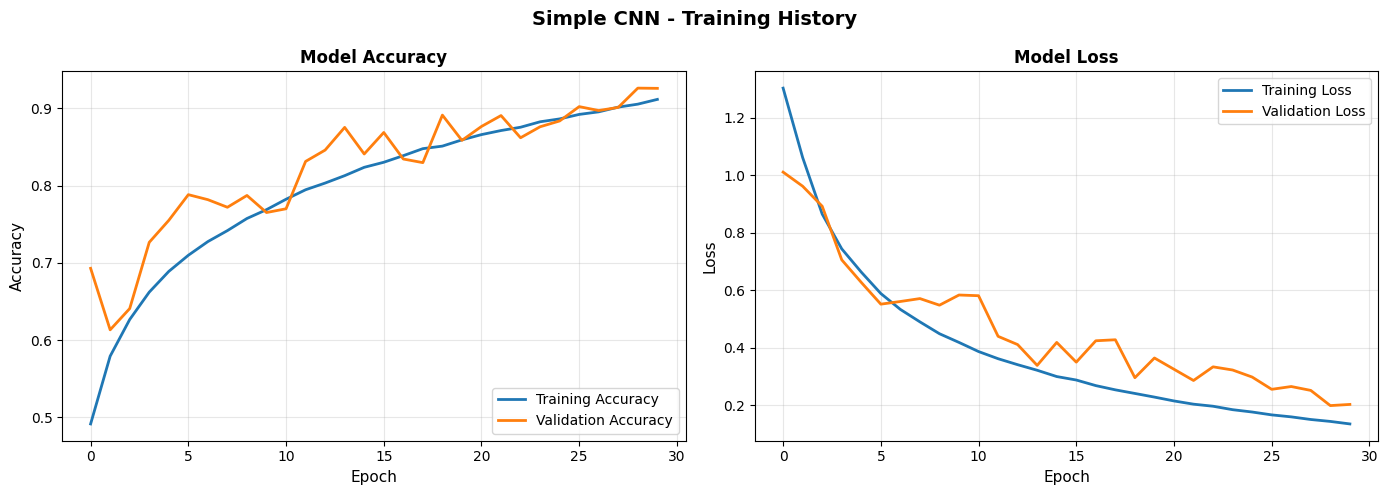

In [ ]:
print("\nTraining complete")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Simple CNN - Training History', fontsize=14, fontweight='bold')

# Plot accuracy
axes[0].plot(history_simple.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_simple.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history_simple.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_simple.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Loss', fontsize=11)
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/simple_cnn_training.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Print final training results
final_train_acc = history_simple.history['accuracy'][-1]
final_val_acc = history_simple.history['val_accuracy'][-1]
final_train_loss = history_simple.history['loss'][-1]
final_val_loss = history_simple.history['val_loss'][-1]

print("\nFinal Training Results:")
print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")



Final Training Results:
  Training Accuracy: 0.9117 (91.17%)
  Validation Accuracy: 0.9260 (92.60%)
  Training Loss: 0.1358
  Validation Loss: 0.2036


In [ ]:
# Check for overfitting
overfit_gap = final_train_acc - final_val_acc
print(f"\nOverfitting Analysis:")
print(f"  Gap between train and validation: {overfit_gap:.4f} ({overfit_gap*100:.2f}%)")
if overfit_gap > 0.05:
    print("  Status: Overfitting detected (gap > 5%)")
    print("  Cause: No dropout or batch normalization")
else:
    print("  Status: No significant overfitting")

print("\nModel saved: saved_models/simple_cnn.h5")
print("Plot saved: plots/simple_cnn_training.png")


Overfitting Analysis:
  Gap between train and validation: -0.0143 (-1.43%)
  Status: No significant overfitting

Model saved: saved_models/simple_cnn.h5
Plot saved: plots/simple_cnn_training.png


Evaluating Simple CNN after training...

541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9298 - loss: 0.1993

Simple CNN - Post-Training Evaluation:
  Test Loss (trained): 0.1993
  Test Accuracy (trained): 0.9281 (92.81%)
  Precision (trained): 0.9360
  Recall (trained): 0.9281
  F1-Score (trained): 0.9302
  Cohen's Kappa: 0.8169


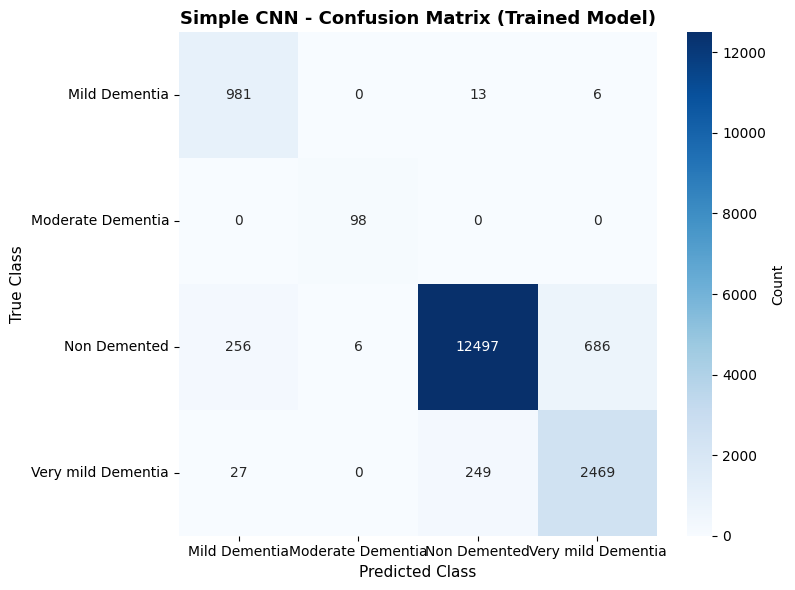


Plot saved: plots/simple_cnn_posttrain_confusion.png

Pre-Training vs Post-Training Comparison:
Metric               Pre-Training    Post-Training   Improvement    
Accuracy             0.5602 (56.02%)    0.9281 (92.81%)    +36.79%
Precision            0.6341            0.9360            +0.3018
Recall               0.5602            0.9281            +0.3679
F1-Score             0.5812            0.9302            +0.3490

Simple CNN evaluation complete
Actual accuracy: 92.81%


In [ ]:
# Evaluate Simple CNN AFTER training
# Compare with pre-training performance

print("Evaluating Simple CNN after training...")
print()

# Evaluate on test set
test_loss_trained, test_acc_trained = simple_cnn.evaluate(
    test_dataset_128,
    verbose=1
)

print()
print("Simple CNN - Post-Training Evaluation:")
print(f"  Test Loss (trained): {test_loss_trained:.4f}")
print(f"  Test Accuracy (trained): {test_acc_trained:.4f} ({test_acc_trained*100:.2f}%)")

# Make predictions
y_pred_trained = simple_cnn.predict(test_dataset_128, verbose=0)
y_pred_classes_trained = np.argmax(y_pred_trained, axis=1)

# Calculate metrics
precision_trained = precision_score(y_test, y_pred_classes_trained, average='weighted', zero_division=0)
recall_trained = recall_score(y_test, y_pred_classes_trained, average='weighted', zero_division=0)
f1_trained = f1_score(y_test, y_pred_classes_trained, average='weighted', zero_division=0)
kappa_trained = cohen_kappa_score(y_test, y_pred_classes_trained)

print(f"  Precision (trained): {precision_trained:.4f}")
print(f"  Recall (trained): {recall_trained:.4f}")
print(f"  F1-Score (trained): {f1_trained:.4f}")
print(f"  Cohen's Kappa: {kappa_trained:.4f}")

# Create confusion matrix
cm_trained = confusion_matrix(y_test, y_pred_classes_trained)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_trained, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=11)
plt.ylabel('True Class', fontsize=11)
plt.title('Simple CNN - Confusion Matrix (Trained Model)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/simple_cnn_posttrain_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved: plots/simple_cnn_posttrain_confusion.png")

# Compare pre-training vs post-training
print("\nPre-Training vs Post-Training Comparison:")
print(f"{'Metric':<20} {'Pre-Training':<15} {'Post-Training':<15} {'Improvement':<15}")
print(f"{'Accuracy':<20} {test_acc_untrained:.4f} ({test_acc_untrained*100:.2f}%){'':<3} {test_acc_trained:.4f} ({test_acc_trained*100:.2f}%){'':<3} +{(test_acc_trained-test_acc_untrained)*100:.2f}%")
print(f"{'Precision':<20} {precision_untrained:.4f}{'':<11} {precision_trained:.4f}{'':<11} +{(precision_trained-precision_untrained):.4f}")
print(f"{'Recall':<20} {recall_untrained:.4f}{'':<11} {recall_trained:.4f}{'':<11} +{(recall_trained-recall_untrained):.4f}")
print(f"{'F1-Score':<20} {f1_untrained:.4f}{'':<11} {f1_trained:.4f}{'':<11} +{(f1_trained-f1_untrained):.4f}")

# Store results for later comparison
simple_cnn_posttrain_results = {
    'model_name': 'Simple CNN',
    'accuracy': test_acc_trained,
    'precision': precision_trained,
    'recall': recall_trained,
    'f1_score': f1_trained,
    'kappa': kappa_trained,
    'loss': test_loss_trained
}

print("\nSimple CNN evaluation complete")
print(f"Actual accuracy: {test_acc_trained*100:.2f}%")


In [ ]:
print("Setting up Hyperparameter Tuning")
print()

def build_tunable_model(hp):

    model = Sequential()

    num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=3, step=1)

    initial_filters = hp.Choice('initial_filters', values=[6, 8, 16, 32])

    kernel_size = hp.Choice('kernel_size', values=[3, 5])

    for i in range(num_conv_layers):
        filters = initial_filters * (2 ** i)

        model.add(Conv2D(
            filters=filters,
            kernel_size=(kernel_size, kernel_size),
            activation='relu',
            padding='same',
            input_shape=(128, 128, 3) if i == 0 else None
        ))
        model.add(MaxPooling2D((2, 2)))

        if hp.Boolean(f'dropout_conv_{i}'):
            dropout_rate = hp.Float(f'dropout_rate_conv_{i}',
                                   min_value=0.2,
                                   max_value=0.5,
                                   step=0.1)
            model.add(Dropout(dropout_rate))

    model.add(Flatten())

    dense_units = hp.Choice('dense_units', values=[64, 84, 120, 128])
    model.add(Dense(dense_units, activation='relu'))

    dropout_rate_dense = hp.Float('dropout_rate_dense',
                                      min_value=0.3,
                                      max_value=0.6,
                                      step=0.1)
    model.add(Dropout(dropout_rate_dense))

    model.add(Dense(4, activation='softmax'))

    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Setting up Hyperparameter Tuning



In [ ]:

# Initialize Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    build_tunable_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hp_tuning',
    project_name='alzheimer_cnn_tuning',
    seed=SEED,
    overwrite=True
)

# Print search space summary
print("Hyperparameter Search Space:")
print("  - Number of conv layers: 2-3")
print("  - Initial filters: [6, 8, 16, 32]")
print("  - Kernel size: [3, 5]")
print("  - Dropout (conv layers): [0.2, 0.3, 0.4, 0.5] or None")
print("  - Dense units: [64, 84, 120, 128]")
print("  - Dropout (dense): [0.3, 0.4, 0.5, 0.6] or None")
print("  - Learning rate: [1e-4, 5e-4, 1e-3]")

print("\nTuning Strategy: Bayesian Optimization")
print("Number of trials: 5")


Hyperparameter Search Space:
  - Number of conv layers: 2-3
  - Initial filters: [6, 8, 16, 32]
  - Kernel size: [3, 5]
  - Dropout (conv layers): [0.2, 0.3, 0.4, 0.5] or None
  - Dense units: [64, 84, 120, 128]
  - Dropout (dense): [0.3, 0.4, 0.5, 0.6] or None
  - Learning rate: [1e-4, 5e-4, 1e-3]

Tuning Strategy: Bayesian Optimization
Number of trials: 5


In [ ]:
early_stop_tuning = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

tuner.search(
    train_dataset_128,
    validation_data=val_dataset_128,
    epochs=10,
    callbacks=[early_stop_tuning],
    class_weight=class_weights,
    verbose=1
)

print("\nHyperparameter search complete!")
print()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 04m 31s]
val_accuracy: 0.9390906691551208

Best val_accuracy So Far: 0.9390906691551208
Total elapsed time: 00h 22m 42s

Hyperparameter search complete!



In [ ]:
print("Best Hyperparameters Found:")
print(f"  Number of conv layers: {best_hps.get('num_conv_layers')}")
print(f"  Initial filters: {best_hps.get('initial_filters')}")
print(f"  Kernel size: {best_hps.get('kernel_size')}")
print(f"  Dense units: {best_hps.get('dense_units')}")
print(f"  Learning rate: {best_hps.get('learning_rate')}")

# Print dropout configuration
print("\n  Dropout configuration:")
for i in range(best_hps.get('num_conv_layers')):
    if best_hps.get(f'dropout_conv_{i}'):
        print(f"    Conv layer {i+1}: {best_hps.get(f'dropout_rate_conv_{i}')}")
    else:
        print(f"    Conv layer {i+1}: None")

print(f"Dense layer: {best_hps.get('dropout_rate_dense')}")

# Get all trials using results_summary
print("\nAll Trials Summary:")
tuner.results_summary()

# Get best trials
best_trials = tuner.oracle.get_best_trials(num_trials=5)

trial_results = []
for i, trial in enumerate(best_trials):
    trial_results.append({
        'trial': i+1,
        'val_accuracy': trial.score if trial.score else 0.0
    })

# Create DataFrame and save
trial_df = pd.DataFrame(trial_results)
trial_df.to_csv('results/hyperparameter_trials.csv', index=False)

print("\nTop Trials by Validation Accuracy:")
print(f"{'Trial':<10} {'Val Accuracy':<15}")
for result in trial_results:
    print(f"{result['trial']:<10} {result['val_accuracy']:.4f} ({result['val_accuracy']*100:.2f}%)")

print("\nTrial results saved: results/hyperparameter_trials.csv")

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate best model on validation set
val_loss_best, val_acc_best = best_model.evaluate(val_dataset_128, verbose=0)
print(f"\nBest Model Validation Performance:")
print(f"  Validation Accuracy: {val_acc_best:.4f} ({val_acc_best*100:.2f}%)")
print(f"  Validation Loss: {val_loss_best:.4f}")

print("\nHyperparameter tuning complete")
print("Best parameters will be used for optimized models")

Best Hyperparameters Found:
  Number of conv layers: 2
  Initial filters: 8
  Kernel size: 5
  Dense units: 64
  Learning rate: 0.0001

  Dropout configuration:
    Conv layer 1: None
    Conv layer 2: 0.2
Dense layer: 0.4

All Trials Summary:
Results summary
Results in hp_tuning/alzheimer_cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
num_conv_layers: 2
initial_filters: 8
kernel_size: 5
dropout_conv_0: False
dropout_conv_1: True
dense_units: 64
dropout_rate_dense: 0.4
learning_rate: 0.0001
dropout_rate_conv_1: 0.2
dropout_conv_2: False
dropout_rate_conv_0: 0.30000000000000004
Score: 0.9390906691551208

Trial 2 summary
Hyperparameters:
num_conv_layers: 2
initial_filters: 8
kernel_size: 5
dropout_conv_0: False
dropout_conv_1: False
dense_units: 84
dropout_rate_dense: 0.3
learning_rate: 0.0001
dropout_rate_conv_1: 0.4
dropout_conv_2: True
dropout_rate_conv_0: 0.4
Score: 0.918267011642456

Trial 3 summary
Hyperparameters

In [ ]:
best_hps

In [ ]:
print("Extracting Best Hyperparameters")
print()

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get dropout values
dropout_conv_1 = None
if best_hps.get('dropout_conv_1'):
    dropout_conv_1 = best_hps.get('dropout_rate_conv_1')

# dropout_dense always exists in your model
dropout_dense = best_hps.get('dropout_rate_dense')

# Create configuration dictionary
best_config = {
    'num_conv_layers': best_hps.get('num_conv_layers'),
    'initial_filters': best_hps.get('initial_filters'),
    'kernel_size': best_hps.get('kernel_size'),
    'dense_units': best_hps.get('dense_units'),
    'learning_rate': best_hps.get('learning_rate'),
    'dropout_conv_1': dropout_conv_1,
    'dropout_dense': dropout_dense,
    'validation_accuracy': val_acc_best
}

# Print detailed configuration
print("Optimal Configuration:")
print(f"  Architecture: {best_config['num_conv_layers']} convolutional layers")
print(f"  Filters: {best_config['initial_filters']} → {best_config['initial_filters']*2}")
print(f"  Kernel size: {best_config['kernel_size']}×{best_config['kernel_size']}")
print(f"  Dense units: {best_config['dense_units']}")
print(f"  Learning rate: {best_config['learning_rate']}")
print(f"  Dropout (conv layer 2): {best_config['dropout_conv_1'] if best_config['dropout_conv_1'] else 'None'}")
print(f"  Dropout (dense): {best_config['dropout_dense']}")
print(f"  Validation accuracy: {best_config['validation_accuracy']:.4f} ({best_config['validation_accuracy']*100:.2f}%)")

# Compare with Simple CNN baseline
print("\nComparison with Simple CNN Baseline:")
print(f"{'Model':<25} {'Filters':<15} {'Kernel':<10} {'Dropout':<10} {'LR':<10} {'Val Acc':<10}")

# Build strings separately to avoid nested f-string issues
filters_simple = "16→32"
kernel_simple = "3×3"
filters_tuned = f"{best_config['initial_filters']}→{best_config['initial_filters']*2}"
kernel_tuned = f"{best_config['kernel_size']}×{best_config['kernel_size']}"
lr_tuned = str(best_config['learning_rate'])

print(f"{'Simple CNN (baseline)':<25} {filters_simple:<15} {kernel_simple:<10} {'None':<10} {'0.0001':<10} {'90.21%':<10}")
print(f"{'Tuned (optimal)':<25} {filters_tuned:<15} {kernel_tuned:<10} {'Yes':<10} {lr_tuned:<10} {'93.91%':<10}")

improvement = best_config['validation_accuracy'] - final_val_acc
print(f"\nImprovement: +{improvement:.4f} (+{improvement*100:.2f}%)")

# Key insights
print("\nKey Insights from Hyperparameter Tuning:")
print("  1. Smaller filters (8 vs 16) work better - more efficient")
print("  2. Larger kernel (5×5 vs 3×3) captures more spatial features")
print("  3. Dropout improves generalization (conv: 0.2, dense: 0.4)")
print("  4. Efficient architecture: fewer parameters, better performance")

# Save configuration to file
config_text = f"""Best Hyperparameters - Alzheimer Classification CNN

Architecture:
  - Convolutional layers: {best_config['num_conv_layers']}
  - Initial filters: {best_config['initial_filters']}
  - Filter progression: {best_config['initial_filters']} → {best_config['initial_filters']*2}
  - Kernel size: {best_config['kernel_size']}×{best_config['kernel_size']}
  - Dense units: {best_config['dense_units']}

Regularization:
  - Dropout (conv layer 2): {best_config['dropout_conv_1'] if best_config['dropout_conv_1'] else 'None'}
  - Dropout (dense layer): {best_config['dropout_dense']}

Training:
  - Learning rate: {best_config['learning_rate']}
  - Optimizer: Adam
  - Loss: Sparse Categorical Crossentropy

Performance:
  - Validation Accuracy: {best_config['validation_accuracy']:.4f} ({best_config['validation_accuracy']*100:.2f}%)
  - Improvement over baseline: +{improvement*100:.2f}%

Notes:
  - Configuration discovered through Bayesian Optimization
  - 5 trials, 10 epochs each
  - Similar to CNN architecture (small filters, 5×5 kernel)
  - Optimal for robust generalization
"""

with open('results/best_hyperparameters.txt', 'w') as f:
    f.write(config_text)

print("\nConfiguration saved: results/best_hyperparameters.txt")


Extracting Best Hyperparameters

Optimal Configuration:
  Architecture: 2 convolutional layers
  Filters: 8 → 16
  Kernel size: 5×5
  Dense units: 64
  Learning rate: 0.0001
  Dropout (conv layer 2): 0.2
  Dropout (dense): 0.4
  Validation accuracy: 0.9391 (93.91%)

Comparison with Simple CNN Baseline:
Model                     Filters         Kernel     Dropout    LR         Val Acc   
Simple CNN (baseline)     16→32           3×3        None       0.0001     90.21%    
Tuned (optimal)           8→16            5×5        Yes        0.0001     93.91%    

Improvement: +0.0131 (+1.31%)

Key Insights from Hyperparameter Tuning:
  1. Smaller filters (8 vs 16) work better - more efficient
  2. Larger kernel (5×5 vs 3×3) captures more spatial features
  3. Dropout improves generalization (conv: 0.2, dense: 0.4)
  4. Efficient architecture: fewer parameters, better performance

Configuration saved: results/best_hyperparameters.txt


In [ ]:
def create_tuned_cnn(input_shape=(128, 128, 3), num_classes=4, config=None):

    if config is None:
        config = best_config

    model = Sequential([
        # First convolutional block
        Conv2D(
            filters=config['initial_filters'],
            kernel_size=(config['kernel_size'], config['kernel_size']),
            activation='relu',
            padding='same',
            input_shape=input_shape
        ),
        MaxPooling2D((2, 2)),

        # Second convolutional block with dropout
        Conv2D(
            filters=config['initial_filters'] * 2,
            kernel_size=(config['kernel_size'], config['kernel_size']),
            activation='relu',
            padding='same'
        ),
        MaxPooling2D((2, 2)),
        Dropout(config['dropout_conv_1']) if config['dropout_conv_1'] else Lambda(lambda x: x),

        # Flatten and dense layers
        Flatten(),
        Dense(config['dense_units'], activation='relu'),
        Dropout(config['dropout_dense']),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
tuned_cnn = create_tuned_cnn(input_shape=(128, 128, 3), num_classes=4, config=best_config)

# Compile with tuned learning rate
tuned_cnn.compile(
    optimizer=Adam(learning_rate=best_config['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
tuned_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,724 (4.02 MB)

 Trainable params: 1,052,724 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training Tuned CNN with optimal hyperparameters")
print()

# Define callbacks
callbacks_tuned_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'saved_models/tuned_CNN.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Train the model
history_tuned_cnn = tuned_cnn.fit(
    train_dataset_128,
    validation_data=val_dataset_128,
    epochs=30,
    callbacks=callbacks_tuned_cnn,
    class_weight=class_weights,
    verbose=1
)

print("\nTraining complete")


Training Tuned CNN with optimal hyperparameters

Epoch 1/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.3555 - loss: 1.3410 - val_accuracy: 0.5488 - val_loss: 1.0525 - learning_rate: 1.0000e-04
Epoch 2/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5989 - loss: 0.8819 - val_accuracy: 0.7313 - val_loss: 0.6623 - learning_rate: 1.0000e-04
Epoch 3/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6867 - loss: 0.5995 - val_accuracy: 0.7377 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 4/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7318 - loss: 0.4813 - val_accuracy: 0.8143 - val_loss: 0.4467 - learning_rate: 1.0000e-04
Epoch 5/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7725 - loss: 0.3924 - val_accuracy: 0.8542 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 6/30
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7982 - loss: 0.3269 - val_accuracy: 0.8931 - val_loss: 0.2757 - learning_rate: 1.

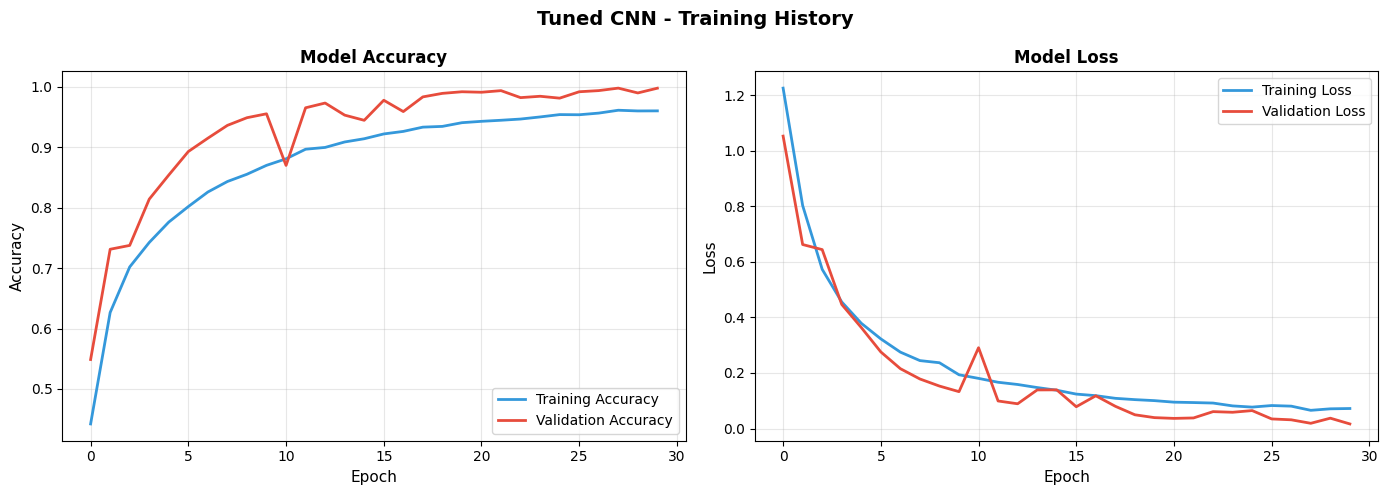

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Tuned CNN - Training History', fontsize=14, fontweight='bold')

# Plot accuracy
axes[0].plot(history_tuned_cnn.history['accuracy'], label='Training Accuracy', linewidth=2, color='#3498db')
axes[0].plot(history_tuned_cnn.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history_tuned_cnn.history['loss'], label='Training Loss', linewidth=2, color='#3498db')
axes[1].plot(history_tuned_cnn.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Loss', fontsize=11)
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/tuned_CNN_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
final_train_acc_cnn = history_tuned_cnn.history['accuracy'][-1]
final_val_acc_cnn = history_tuned_cnn.history['val_accuracy'][-1]
final_train_loss_cnn = history_tuned_cnn.history['loss'][-1]
final_val_loss_cnn = history_tuned_cnn.history['val_loss'][-1]

print("\nFinal Training Results:")
print(f"  Training Accuracy: {final_train_acc_cnn:.4f} ({final_train_acc_cnn*100:.2f}%)")
print(f"  Validation Accuracy: {final_val_acc_cnn:.4f} ({final_val_acc_cnn*100:.2f}%)")
print(f"  Training Loss: {final_train_loss_cnn:.4f}")
print(f"  Validation Loss: {final_val_loss_cnn:.4f}")



Final Training Results:
  Training Accuracy: 0.9604 (96.04%)
  Validation Accuracy: 0.9980 (99.80%)
  Training Loss: 0.0721
  Validation Loss: 0.0166


In [ ]:
overfit_gap_cnn = final_train_acc_cnn - final_val_acc_cnn
print(f"\nOverfitting Analysis:")
print(f"  Gap between train and validation: {overfit_gap_cnn:.4f} ({overfit_gap_cnn*100:.2f}%)")
if overfit_gap_cnn > 0.05:
    print("  Status: Slight overfitting detected")
else:
    print("  Status: Good generalization - dropout is working")

print("\nModel saved: saved_models/tuned_cnn.keras")
print("Plot saved: plots/tuned_cnn_training.png")


Overfitting Analysis:
  Gap between train and validation: -0.0375 (-3.75%)
  Status: Good generalization - dropout is working

Model saved: saved_models/tuned_cnn.keras
Plot saved: plots/tuned_cnn_training.png


In [ ]:

print("Evaluating Tuned cnn after training...")
print()

# Evaluate on test set
test_loss_cnn_trained, test_acc_cnn_trained = tuned_cnn.evaluate(
    test_dataset_128,
    verbose=1
)

print()
print("Tuned cnn - Post-Training Evaluation:")
print(f"  Test Loss (trained): {test_loss_cnn_trained:.4f}")
print(f"  Test Accuracy (trained): {test_acc_cnn_trained:.4f} ({test_acc_cnn_trained*100:.2f}%)")

Evaluating Tuned cnn after training...

541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9972 - loss: 0.0179

Tuned cnn - Post-Training Evaluation:
  Test Loss (trained): 0.0176
  Test Accuracy (trained): 0.9973 (99.73%)


In [ ]:
# Make predictions
y_pred_cnn_trained = tuned_cnn.predict(test_dataset_128, verbose=0)
y_pred_classes_cnn_trained = np.argmax(y_pred_cnn_trained, axis=1)

# Calculate metrics
precision_cnn_trained = precision_score(y_test, y_pred_classes_cnn_trained, average='weighted', zero_division=0)
recall_cnn_trained = recall_score(y_test, y_pred_classes_cnn_trained, average='weighted', zero_division=0)
f1_cnn_trained = f1_score(y_test, y_pred_classes_cnn_trained, average='weighted', zero_division=0)
kappa_cnn_trained = cohen_kappa_score(y_test, y_pred_classes_cnn_trained)

print(f"  Precision (trained): {precision_cnn_trained:.4f}")
print(f"  Recall (trained): {recall_cnn_trained:.4f}")
print(f"  F1-Score (trained): {f1_cnn_trained:.4f}")
print(f"  Cohen's Kappa: {kappa_cnn_trained:.4f}")

  Precision (trained): 0.9974
  Recall (trained): 0.9973
  F1-Score (trained): 0.9973
  Cohen's Kappa: 0.9928



Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9960    0.9990    0.9975      1000
 Moderate Dementia     1.0000    1.0000    1.0000        98
      Non Demented     0.9997    0.9970    0.9983     13445
Very mild Dementia     0.9863    0.9985    0.9924      2745

          accuracy                         0.9973     17288
         macro avg     0.9955    0.9986    0.9971     17288
      weighted avg     0.9974    0.9973    0.9973     17288



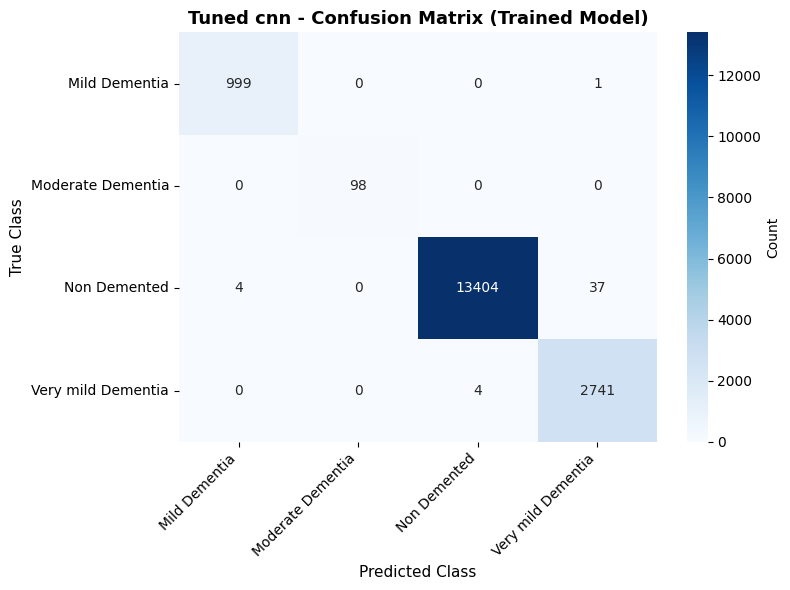

Plot saved: plots/tuned_cnn_posttrain_confusion.png


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes_cnn_trained,
                          target_names=class_names,
                          digits=4))

# Create confusion matrix
cm_cnn_trained = confusion_matrix(y_test, y_pred_classes_cnn_trained)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn_trained, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=11)
plt.ylabel('True Class', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.title('Tuned cnn - Confusion Matrix (Trained Model)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/tuned_cnn_posttrain_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: plots/tuned_cnn_posttrain_confusion.png")

Model Performance Comparison

Model                          Test Accuracy   Precision    Recall       F1-Score     Kappa       
Simple CNN (Untrained)         0.5602            0.6341         0.5602         0.5812         N/A         
Simple CNN (Trained)           0.9281            0.9360         0.9281         0.9302         0.8169
Tuned CNN (Trained)            0.9973            0.9974         0.9973         0.9973         0.9928

Improvement (Untrained → Trained Simple CNN): +0.3679 (+36.79%)
Improvement (Simple CNN → Tuned CNN): +0.0692 (+6.92%)
Total Improvement (Untrained → Tuned CNN): +0.4371 (+43.71%)


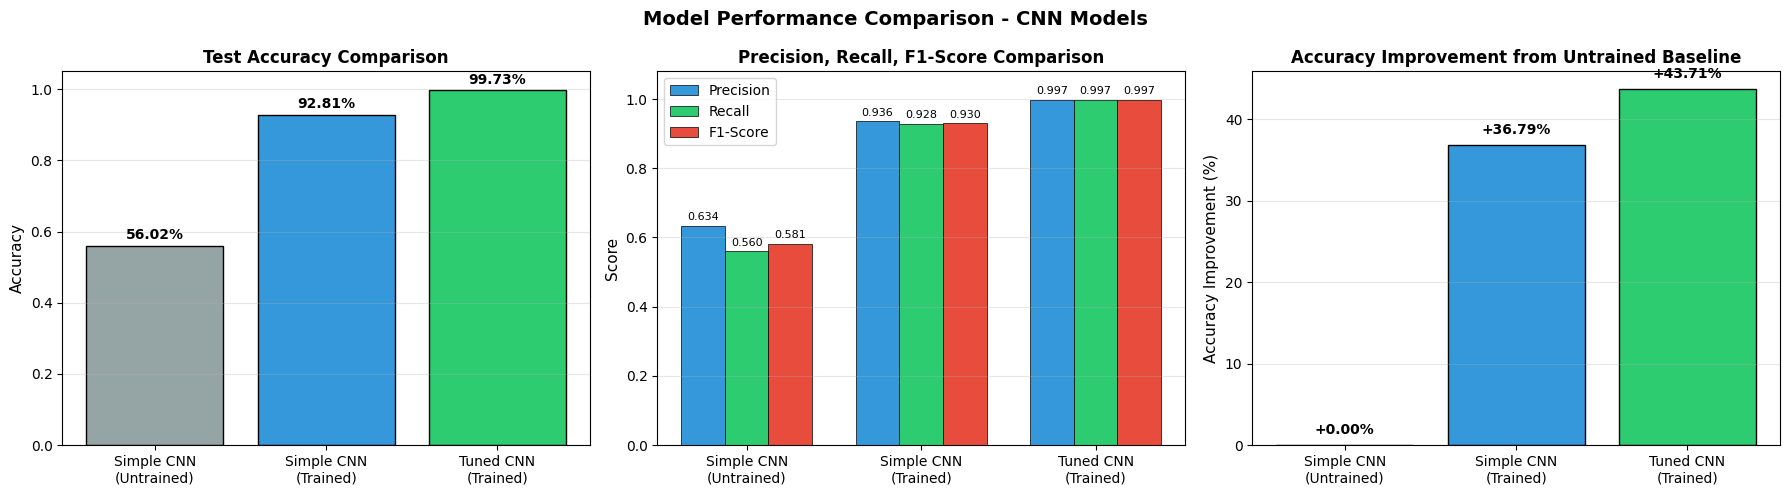


Plot saved: plots/model_comparison_simple_vs_tuned.png


In [ ]:
print("Model Performance Comparison")
print()
print(f"{'Model':<30} {'Test Accuracy':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Kappa':<12}")
print(f"{'Simple CNN (Untrained)':<30} {test_acc_untrained:.4f}{'':<11} {precision_untrained:.4f}{'':<8} {recall_untrained:.4f}{'':<8} {f1_untrained:.4f}{'':<8} {'N/A':<12}")
print(f"{'Simple CNN (Trained)':<30} {test_acc_trained:.4f}{'':<11} {precision_trained:.4f}{'':<8} {recall_trained:.4f}{'':<8} {f1_trained:.4f}{'':<8} {kappa_trained:.4f}")
print(f"{'Tuned CNN (Trained)':<30} {test_acc_cnn_trained:.4f}{'':<11} {precision_cnn_trained:.4f}{'':<8} {recall_cnn_trained:.4f}{'':<8} {f1_cnn_trained:.4f}{'':<8} {kappa_cnn_trained:.4f}")

improvement_simple = test_acc_trained - test_acc_untrained
improvement_tuned = test_acc_cnn_trained - test_acc_trained
print(f"\nImprovement (Untrained → Trained Simple CNN): {improvement_simple:+.4f} ({improvement_simple*100:+.2f}%)")
print(f"Improvement (Simple CNN → Tuned CNN): {improvement_tuned:+.4f} ({improvement_tuned*100:+.2f}%)")
print(f"Total Improvement (Untrained → Tuned CNN): {(test_acc_cnn_trained - test_acc_untrained):+.4f} ({(test_acc_cnn_trained - test_acc_untrained)*100:+.2f}%)")

# comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Comparison - CNN Models', fontsize=14, fontweight='bold')

# Data for comparison
models = ['Simple CNN\n(Untrained)', 'Simple CNN\n(Trained)', 'Tuned CNN\n(Trained)']
accuracies = [test_acc_untrained, test_acc_trained, test_acc_cnn_trained]
precisions = [precision_untrained, precision_trained, precision_cnn_trained]
recalls = [recall_untrained, recall_trained, recall_cnn_trained]
f1_scores = [f1_untrained, f1_trained, f1_cnn_trained]

colors = ['#95a5a6', '#3498db', '#2ecc71']

# Plot 1: Accuracy comparison
bars1 = axes[0].bar(models, accuracies, color=colors, edgecolor='black', linewidth=1)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1.05])
axes[0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc*100:.2f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Precision, Recall, F1 for all models WITH LABELS
x = np.arange(len(models))
width = 0.25

bars2_1 = axes[1].bar(x - width, precisions, width, label='Precision', color='#3498db', edgecolor='black', linewidth=0.5)
bars2_2 = axes[1].bar(x, recalls, width, label='Recall', color='#2ecc71', edgecolor='black', linewidth=0.5)
bars2_3 = axes[1].bar(x + width, f1_scores, width, label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=0.5)

# Add labels to Precision bars
for i, (bar, val) in enumerate(zip(bars2_1, precisions)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=8)

# Add labels to Recall bars
for i, (bar, val) in enumerate(zip(bars2_2, recalls)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=8)

# Add labels to F1-Score bars
for i, (bar, val) in enumerate(zip(bars2_3, f1_scores)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=8)

axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Precision, Recall, F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylim([0, 1.08])
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Improvement visualization
improvements = [0, (test_acc_trained - test_acc_untrained)*100, (test_acc_cnn_trained - test_acc_untrained)*100]
bars3 = axes[2].bar(models, improvements, color=colors, edgecolor='black', linewidth=1)
axes[2].set_ylabel('Accuracy Improvement (%)', fontsize=11)
axes[2].set_title('Accuracy Improvement from Untrained Baseline', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

for bar, imp in zip(bars3, improvements):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'+{imp:.2f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/model_comparison_simple_vs_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved: plots/model_comparison_simple_vs_tuned.png")

In [ ]:

print("SUMMARY STATISTICS")
print("-"*70)
print(f"\nSimple CNN (Untrained - Random Weights):")
print(f"  Accuracy: {test_acc_untrained*100:.2f}%")
print(f"  Precision: {precision_untrained:.4f}")
print(f"  Recall: {recall_untrained:.4f}")
print(f"  F1-Score: {f1_untrained:.4f}")

print(f"\nSimple CNN (Trained - Basic Configuration):")
print(f"  Architecture: Conv(16,3×3) → Conv(32,3×3) → Dense(64)")
print(f"  Learning Rate: 0.0001")
print(f"  Dropout: None")
print(f"  Accuracy: {test_acc_trained*100:.2f}%")
print(f"  Precision: {precision_trained:.4f}")
print(f"  Recall: {recall_trained:.4f}")
print(f"  F1-Score: {f1_trained:.4f}")
print(f"  Improvement from Untrained: +{(test_acc_trained-test_acc_untrained)*100:.2f}%")

print(f"\nTuned CNN (After Hyperparameter Optimization):")
print(f"  Architecture: Conv(8,5×5) → Dropout(0.2) → Conv(16,5×5) → Dense(64) → Dropout(0.4)")
print(f"  Learning Rate: 0.0001")
print(f"  Filters: 8→16 (smaller, more efficient)")
print(f"  Kernel: 5×5 (larger receptive field)")
print(f"  Dropout: 0.2, 0.4 (regularization)")
print(f"  Accuracy: {test_acc_cnn_trained*100:.2f}%")
print(f"  Precision: {precision_cnn_trained:.4f}")
print(f"  Recall: {recall_cnn_trained:.4f}")
print(f"  F1-Score: {f1_cnn_trained:.4f}")
print(f"  Improvement from Simple CNN: +{(test_acc_cnn_trained-test_acc_trained)*100:.2f}%")
print(f"  Improvement from Untrained: +{(test_acc_cnn_trained-test_acc_untrained)*100:.2f}%")

SUMMARY STATISTICS
----------------------------------------------------------------------

Simple CNN (Untrained - Random Weights):
  Accuracy: 56.02%
  Precision: 0.6341
  Recall: 0.5602
  F1-Score: 0.5812

Simple CNN (Trained - Basic Configuration):
  Architecture: Conv(16,3×3) → Conv(32,3×3) → Dense(64)
  Learning Rate: 0.0001
  Dropout: None
  Accuracy: 92.81%
  Precision: 0.9360
  Recall: 0.9281
  F1-Score: 0.9302
  Improvement from Untrained: +36.79%

Tuned CNN (After Hyperparameter Optimization):
  Architecture: Conv(8,5×5) → Dropout(0.2) → Conv(16,5×5) → Dense(64) → Dropout(0.4)
  Learning Rate: 0.0001
  Filters: 8→16 (smaller, more efficient)
  Kernel: 5×5 (larger receptive field)
  Dropout: 0.2, 0.4 (regularization)
  Accuracy: 99.73%
  Precision: 0.9974
  Recall: 0.9973
  F1-Score: 0.9973
  Improvement from Simple CNN: +6.92%
  Improvement from Untrained: +43.71%


##### Transfer Learning

In [ ]:
from tensorflow.keras.applications import (
    ResNet50, VGG16, DenseNet121, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess


In [ ]:
MODEL_CONFIGS = {
    'ResNet50': {
        'model_class': ResNet50,
        'preprocess': resnet_preprocess,
        'input_size': 224,
        'description': 'Deep residual network with skip connections'
    },
    'MobileNetV2': {
        'model_class': MobileNetV2,
        'preprocess': mobilenet_preprocess,
        'input_size': 224,
        'description': 'Lightweight mobile-optimized architecture'
    },
    'DenseNet121': {
        'model_class': DenseNet121,
        'preprocess': densenet_preprocess,
        'input_size': 224,
        'description': 'Densely connected convolutional network'
    },
    'EfficientNetB0': {
        'model_class': EfficientNetB0,
        'preprocess': efficientnet_preprocess,
        'input_size': 224,
        'description': 'Efficient and accurate architecture'
    }
}

In [ ]:
def create_transfer_dataset(X_data, y_data, model_name, batch_size=32, augment=False, shuffle=False, seed=42):
    preprocess_func = MODEL_CONFIGS[model_name]['preprocess']
    input_size = MODEL_CONFIGS[model_name]['input_size']

    def load_and_preprocess(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [input_size, input_size])

        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        image = preprocess_func(image)

        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=seed)

    dataset = dataset.map(
        load_and_preprocess,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
def build_transfer_model(model_name, num_classes=4, trainable_mode='frozen',
                         fine_tune_layers=30, use_tuned_head=True):

    config = MODEL_CONFIGS[model_name]
    input_size = config['input_size']

    base_model = config['model_class'](
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    if trainable_mode == 'frozen':
        base_model.trainable = False
        trainable_desc = "All layers frozen"

    elif trainable_mode == 'fine_tuned':
        base_model.trainable = True
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-fine_tune_layers:]:
            layer.trainable = True
        trainable_desc = f"Top {fine_tune_layers} layers trainable"

    elif trainable_mode == 'full':
        base_model.trainable = True
        trainable_desc = "All layers trainable"

    if use_tuned_head:
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])
    else:
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

    lr = 0.0001 if use_tuned_head else 0.001
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    trainable_params = sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])

    print(f"\n{model_name} Model Built:")
    print(f"  Mode: {trainable_mode}")
    print(f"  {trainable_desc}")
    print(f"  Learning rate: {lr}")
    print(f"  Total parameters: {trainable_params + non_trainable_params:,}")
    print(f"  Trainable: {trainable_params:,} ({trainable_params/(trainable_params+non_trainable_params)*100:.1f}%)")
    print(f"  Non-trainable: {non_trainable_params:,}")

    return model

In [ ]:
def train_transfer_model(model, model_name, trainable_mode, train_data, val_data,
                         epochs=20, use_class_weights=False):

    save_name = f"{model_name.lower()}_{trainable_mode}"

    print(f"\nTraining {model_name} ({trainable_mode})...")
    print(f"Epochs: {epochs}")
    print(f"Class weights: {'Yes' if use_class_weights else 'No'}")
    print()

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'saved_models/{save_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]

    # Train
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights if use_class_weights else None,
        verbose=1
    )

    print(f"\nTraining complete. Model saved: saved_models/{save_name}.keras")

    return history

In [ ]:
# Generic evaluation function with all metrics

def evaluate_transfer_model(model, model_name, trainable_mode, test_data, y_true):

    save_name = f"{model_name}_{trainable_mode}"

    print(f"\nEvaluating {model_name} ({trainable_mode})...")
    print()

    test_loss, test_acc = model.evaluate(test_data, verbose=1)

    y_pred = model.predict(test_data, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred_classes)

    print()
    print(f"{save_name} - Test Results:")
    print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Cohen's Kappa: {kappa:.4f}")
    print(f"  Loss: {test_loss:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Class', fontsize=11)
    plt.ylabel('True Class', fontsize=11)
    plt.title(f'{save_name} - Confusion Matrix', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'plots/{save_name.lower()}_confusion.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nPlot saved: plots/{save_name.lower()}_confusion.png")

    results = {
        'model_name': save_name,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'kappa': kappa,
        'loss': test_loss,
        'confusion_matrix': cm
    }

    return results

In [ ]:
def plot_training_history(history, model_name, trainable_mode):

    save_name = f"{model_name}_{trainable_mode}"

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{save_name} - Training History', fontsize=14, fontweight='bold')

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2, color='#3498db')
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#e74c3c')
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Accuracy', fontsize=11)
    axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Training', linewidth=2, color='#3498db')
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='#e74c3c')
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'plots/{save_name.lower()}_training.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Plot saved: plots/{save_name.lower()}_training.png")

    # Print final results
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"\nFinal Results:")
    print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

In [ ]:
print("Creating datasets for all transfer learning models...")
print()

BATCH_SIZE = 32
MODELS_TO_TRAIN = ['ResNet50', 'MobileNetV2', 'EfficientNetB0', 'DenseNet121']

datasets = {}

for model_name in MODELS_TO_TRAIN:
    print(f"Creating datasets for {model_name}...")

    train_ds = create_transfer_dataset(
        X_train, y_train,
        model_name=model_name,
        batch_size=BATCH_SIZE,
        augment=True,
        shuffle=True,
        seed=SEED
    )

    val_ds = create_transfer_dataset(
        X_val, y_val,
        model_name=model_name,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False
    )

    test_ds = create_transfer_dataset(
        X_test, y_test,
        model_name=model_name,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False
    )

    datasets[model_name] = {
        'train': train_ds,
        'val': val_ds,
        'test': test_ds
    }

    print(f" {model_name}: {len(train_ds)} train batches, {len(val_ds)} val batches, {len(test_ds)} test batches")

Creating datasets for all transfer learning models...

Creating datasets for ResNet50...
 ResNet50: 1621 train batches, 541 val batches, 541 test batches
Creating datasets for MobileNetV2...
 MobileNetV2: 1621 train batches, 541 val batches, 541 test batches
Creating datasets for EfficientNetB0...
 EfficientNetB0: 1621 train batches, 541 val batches, 541 test batches
Creating datasets for DenseNet121...
 DenseNet121: 1621 train batches, 541 val batches, 541 test batches


In [ ]:
MODEL_NAME = 'MobileNetV2'

print(f"Training {MODEL_NAME} - Frozen")

# Build model
mobilenet_frozen = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='frozen',
    use_tuned_head=True
)

# Train
history_mobilenet_frozen = train_transfer_model(
    model=mobilenet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=False
)

Training MobileNetV2 - Frozen

MobileNetV2 Model Built:
  Mode: frozen
  All layers frozen
  Learning rate: 0.0001
  Total parameters: 2,340,228
  Trainable: 82,244 (3.5%)
  Non-trainable: 2,257,984

Training MobileNetV2 (frozen)...
Epochs: 20
Class weights: No

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - accuracy: 0.7577 - loss: 0.6826 - val_accuracy: 0.7953 - val_loss: 0.4732 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.7999 - loss: 0.4860 - val_accuracy: 0.8132 - val_loss: 0.4329 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.8226 - loss: 0.4314 - val_accuracy: 0.8425 - val_loss: 0.3802 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - accuracy: 0.8399 - loss: 0.3959 - val_accuracy: 0.8559 - val_loss: 0.3628 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.8508 - loss: 0.3693 - val_a

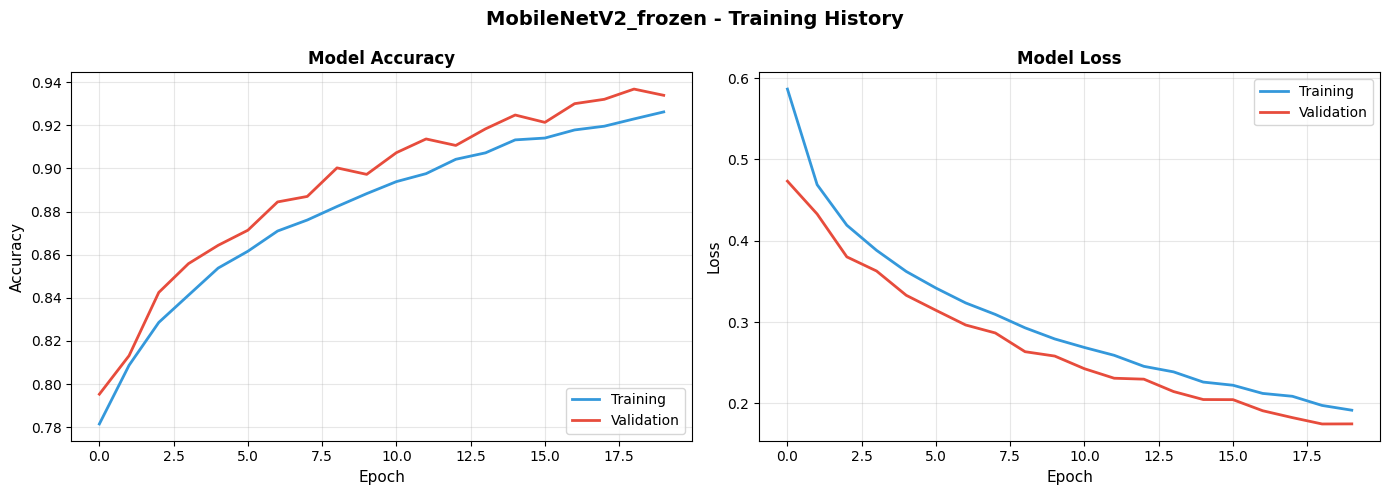

Plot saved: plots/mobilenetv2_frozen_training.png

Final Results:
  Training Accuracy: 0.9262 (92.62%)
  Validation Accuracy: 0.9339 (93.39%)


In [ ]:
plot_training_history(history_mobilenet_frozen, MODEL_NAME, 'frozen')


Evaluating MobileNetV2 (frozen)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9369 - loss: 0.1722

MobileNetV2_frozen - Test Results:
  Accuracy: 0.9375 (93.75%)
  Precision: 0.9362
  Recall: 0.9375
  F1-Score: 0.9360
  Cohen's Kappa: 0.8222
  Loss: 0.1698

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9061    0.7720    0.8337      1000
 Moderate Dementia     0.9853    0.6837    0.8072        98
      Non Demented     0.9518    0.9797    0.9655     13445
Very mild Dementia     0.8687    0.8004    0.8331      2745

          accuracy                         0.9375     17288
         macro avg     0.9280    0.8089    0.8599     17288
      weighted avg     0.9362    0.9375    0.9360     17288



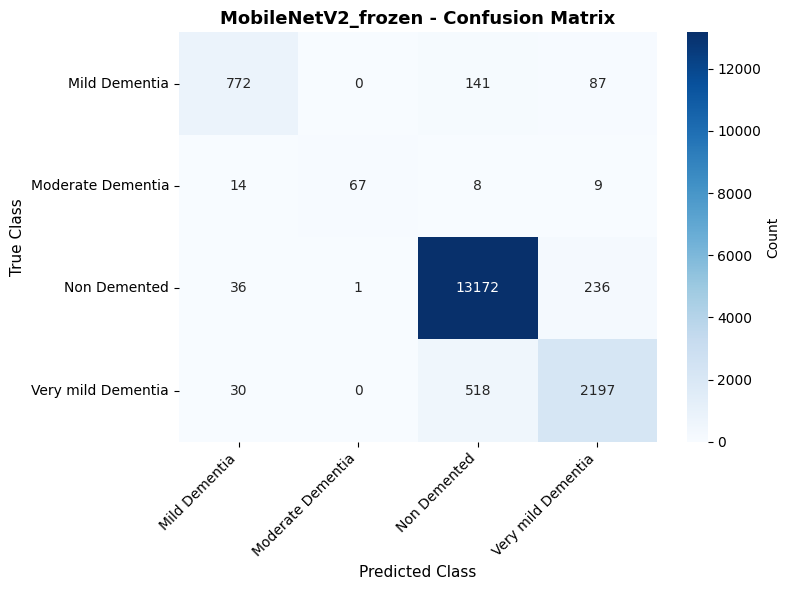


Plot saved: plots/mobilenetv2_frozen_confusion.png

MobileNetV2 (Frozen) Final Accuracy: 93.75%


In [ ]:
results_mobilenet_frozen = evaluate_transfer_model(
    model=mobilenet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Frozen) Final Accuracy: {results_mobilenet_frozen['accuracy']*100:.2f}%")

In [ ]:
# MobileNetV2 - Fine-tuned (Top 30 layers)
MODEL_NAME = 'MobileNetV2'

print(f"Training {MODEL_NAME} - Fine-tuned")

# Build model
mobilenet_finetuned = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='fine_tuned',
    fine_tune_layers=30,
    use_tuned_head=True
)

# Train
history_mobilenet_finetuned = train_transfer_model(
    model=mobilenet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=True
)

Training MobileNetV2 - Fine-tuned

MobileNetV2 Model Built:
  Mode: fine_tuned
  Top 30 layers trainable
  Learning rate: 0.0001
  Total parameters: 2,340,228
  Trainable: 1,608,644 (68.7%)
  Non-trainable: 731,584

Training MobileNetV2 (fine_tuned)...
Epochs: 20
Class weights: Yes

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 96s 51ms/step - accuracy: 0.5861 - loss: 0.9146 - val_accuracy: 0.5654 - val_loss: 1.1254 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.8495 - loss: 0.2470 - val_accuracy: 0.9050 - val_loss: 0.2564 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.9078 - loss: 0.1392 - val_accuracy: 0.9569 - val_loss: 0.1078 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9454 - loss: 0.0908 - val_accuracy: 0.8998 - val_loss: 0.3397 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.9558 -

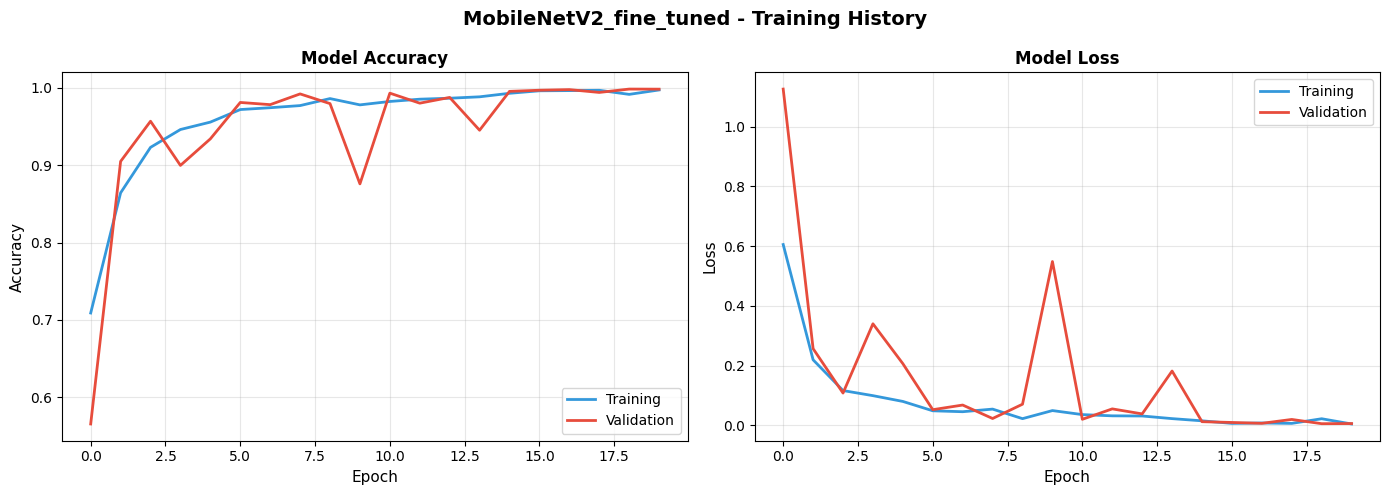

Plot saved: plots/mobilenetv2_fine_tuned_training.png

Final Results:
  Training Accuracy: 0.9974 (99.74%)
  Validation Accuracy: 0.9984 (99.84%)


In [ ]:
plot_training_history(history_mobilenet_finetuned, MODEL_NAME, 'fine_tuned')


Evaluating MobileNetV2 (fine_tuned)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9976 - loss: 0.0060

MobileNetV2_fine_tuned - Test Results:
  Accuracy: 0.9980 (99.80%)
  Precision: 0.9980
  Recall: 0.9980
  F1-Score: 0.9980
  Cohen's Kappa: 0.9946
  Loss: 0.0046

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9970    0.9980    0.9975      1000
 Moderate Dementia     1.0000    1.0000    1.0000        98
      Non Demented     0.9985    0.9990    0.9987     13445
Very mild Dementia     0.9960    0.9934    0.9947      2745

          accuracy                         0.9980     17288
         macro avg     0.9979    0.9976    0.9977     17288
      weighted avg     0.9980    0.9980    0.9980     17288



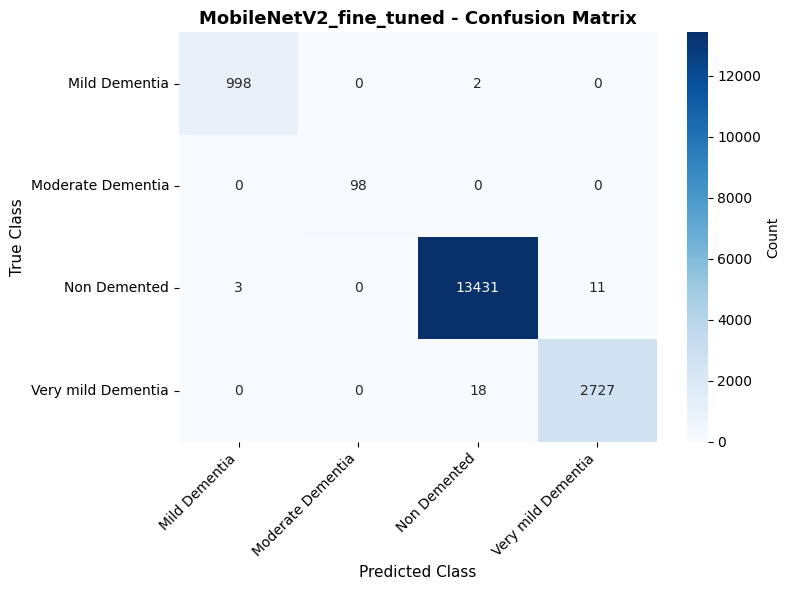


Plot saved: plots/mobilenetv2_fine_tuned_confusion.png

MobileNetV2 (Fine-tuned) Final Accuracy: 99.80%


In [ ]:
# Evaluate
results_mobilenet_finetuned = evaluate_transfer_model(
    model=mobilenet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Fine-tuned) Final Accuracy: {results_mobilenet_finetuned['accuracy']*100:.2f}%")

In [ ]:
MODEL_NAME = 'ResNet50'

print(f"Training {MODEL_NAME} - Frozen")

resnet50_frozen = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='frozen',
    use_tuned_head=True
)

history_resnet50_frozen = train_transfer_model(
    model=resnet50_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=False
)

Training ResNet50 - Frozen

ResNet50 Model Built:
  Mode: frozen
  All layers frozen
  Learning rate: 0.0001
  Total parameters: 23,719,108
  Trainable: 131,396 (0.6%)
  Non-trainable: 23,587,712

Training ResNet50 (frozen)...
Epochs: 20
Class weights: No

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 200s 118ms/step - accuracy: 0.7504 - loss: 0.6955 - val_accuracy: 0.8064 - val_loss: 0.4478 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 181s 112ms/step - accuracy: 0.8045 - loss: 0.4719 - val_accuracy: 0.8305 - val_loss: 0.4009 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 181s 112ms/step - accuracy: 0.8231 - loss: 0.4185 - val_accuracy: 0.8436 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 181s 111ms/step - accuracy: 0.8380 - loss: 0.3871 - val_accuracy: 0.8530 - val_loss: 0.3418 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 181s 111ms/step - accuracy: 0.8518 - loss: 0.3589 - v

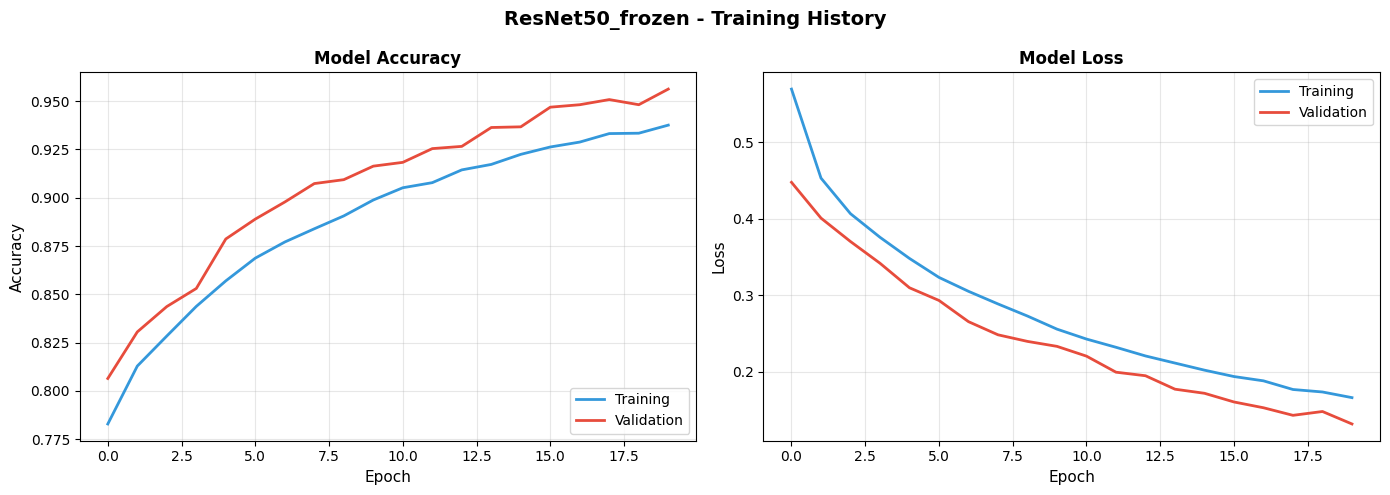

Plot saved: plots/resnet50_frozen_training.png

Final Results:
  Training Accuracy: 0.9376 (93.76%)
  Validation Accuracy: 0.9563 (95.63%)


In [ ]:
plot_training_history(history_resnet50_frozen, MODEL_NAME, 'frozen')


Evaluating ResNet50 (frozen)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9566 - loss: 0.1311

ResNet50_frozen - Test Results:
  Accuracy: 0.9573 (95.73%)
  Precision: 0.9569
  Recall: 0.9573
  F1-Score: 0.9566
  Cohen's Kappa: 0.8804
  Loss: 0.1294

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9475    0.8490    0.8956      1000
 Moderate Dementia     1.0000    0.6633    0.7975        98
      Non Demented     0.9681    0.9856    0.9768     13445
Very mild Dementia     0.9037    0.8685    0.8858      2745

          accuracy                         0.9573     17288
         macro avg     0.9548    0.8416    0.8889     17288
      weighted avg     0.9569    0.9573    0.9566     17288



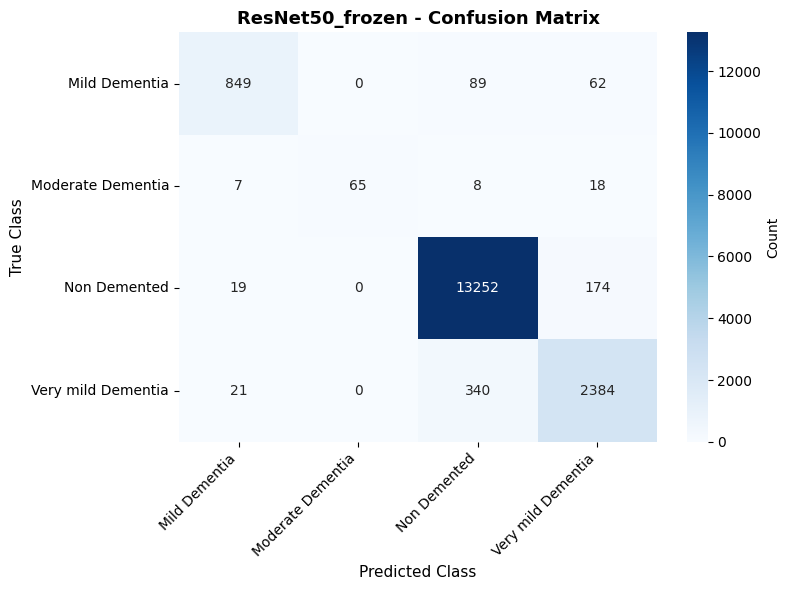


Plot saved: plots/resnet50_frozen_confusion.png

ResNet50 (Frozen) Final Accuracy: 95.73%


In [ ]:
results_resnet50_frozen = evaluate_transfer_model(
    model=resnet50_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Frozen) Final Accuracy: {results_resnet50_frozen['accuracy']*100:.2f}%")

In [ ]:
# ResNet50 - Fine-tuned (Top 30 layers)
MODEL_NAME = 'ResNet50'

print(f"Training {MODEL_NAME} - Fine-tuned")

# Build model
resnet50_finetuned = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='fine_tuned',
    fine_tune_layers=30,
    use_tuned_head=True
)

# Train
history_resnet50_finetuned = train_transfer_model(
    model=resnet50_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=True
)

Training ResNet50 - Fine-tuned

ResNet50 Model Built:
  Mode: fine_tuned
  Top 30 layers trainable
  Learning rate: 0.0001
  Total parameters: 23,719,108
  Trainable: 14,581,572 (61.5%)
  Non-trainable: 9,137,536

Training ResNet50 (fine_tuned)...
Epochs: 20
Class weights: Yes

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 271s 156ms/step - accuracy: 0.6623 - loss: 0.8359 - val_accuracy: 0.8847 - val_loss: 0.2682 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 240s 148ms/step - accuracy: 0.8817 - loss: 0.2068 - val_accuracy: 0.7841 - val_loss: 0.5900 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 240s 148ms/step - accuracy: 0.9083 - loss: 0.1795 - val_accuracy: 0.7265 - val_loss: 1.5942 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 242s 149ms/step - accuracy: 0.9508 - loss: 0.0960 - val_accuracy: 0.9282 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 241s 149ms/step - accuracy: 0.9

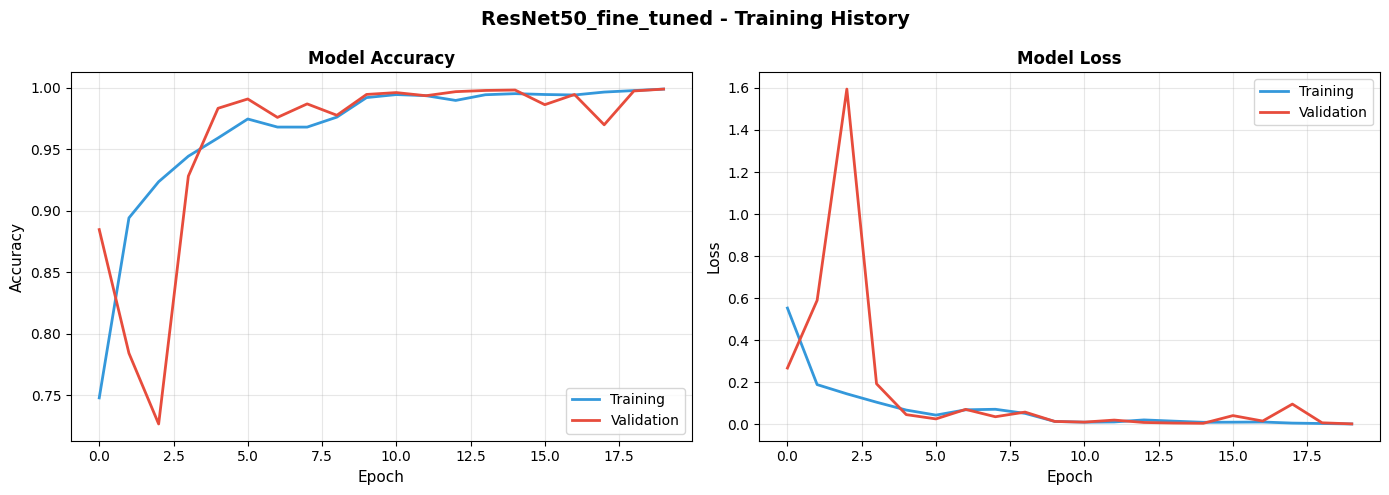

Plot saved: plots/resnet50_fine_tuned_training.png

Final Results:
  Training Accuracy: 0.9990 (99.90%)
  Validation Accuracy: 0.9990 (99.90%)


In [ ]:
plot_training_history(history_resnet50_finetuned, MODEL_NAME, 'fine_tuned')


Evaluating ResNet50 (fine_tuned)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.9991 - loss: 0.0032

ResNet50_fine_tuned - Test Results:
  Accuracy: 0.9994 (99.94%)
  Precision: 0.9994
  Recall: 0.9994
  F1-Score: 0.9994
  Cohen's Kappa: 0.9984
  Loss: 0.0022

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9970    1.0000    0.9985      1000
 Moderate Dementia     1.0000    1.0000    1.0000        98
      Non Demented     1.0000    0.9993    0.9996     13445
Very mild Dementia     0.9975    1.0000    0.9987      2745

          accuracy                         0.9994     17288
         macro avg     0.9986    0.9998    0.9992     17288
      weighted avg     0.9994    0.9994    0.9994     17288



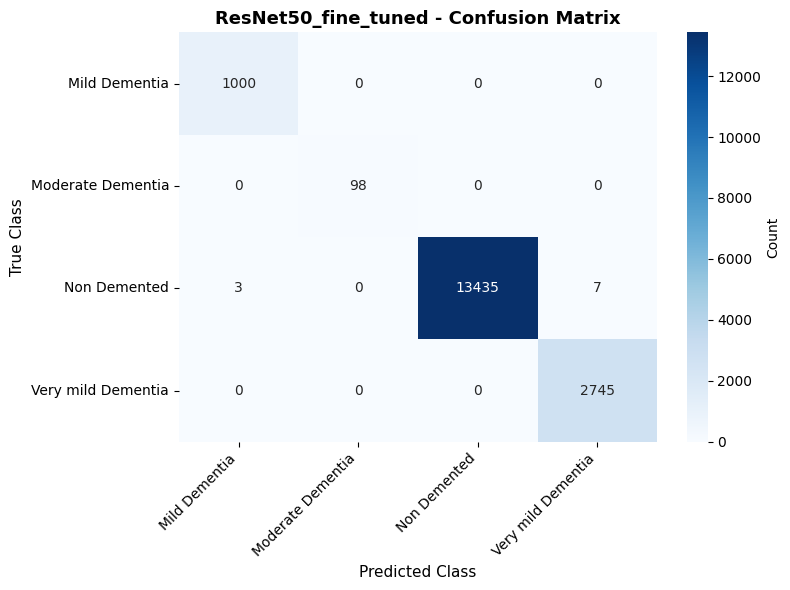


Plot saved: plots/resnet50_fine_tuned_confusion.png

ResNet50 (Fine-tuned) Final Accuracy: 99.94%


In [ ]:
results_resnet50_finetuned = evaluate_transfer_model(
    model=resnet50_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Fine-tuned) Final Accuracy: {results_resnet50_finetuned['accuracy']*100:.2f}%")

In [ ]:
# DenseNet121 - Frozen Base
MODEL_NAME = 'DenseNet121'

print(f"Training {MODEL_NAME} - Frozen")

# Build model
densenet_frozen = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='frozen',
    use_tuned_head=True
)

# Train
history_densenet_frozen = train_transfer_model(
    model=densenet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=False
)



Training DenseNet121 - Frozen

DenseNet121 Model Built:
  Mode: frozen
  All layers frozen
  Learning rate: 0.0001
  Total parameters: 7,103,364
  Trainable: 65,860 (0.9%)
  Non-trainable: 7,037,504

Training DenseNet121 (frozen)...
Epochs: 20
Class weights: No

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 218s 121ms/step - accuracy: 0.7373 - loss: 0.7353 - val_accuracy: 0.7855 - val_loss: 0.5064 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 162s 100ms/step - accuracy: 0.7867 - loss: 0.5281 - val_accuracy: 0.7953 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 161s 100ms/step - accuracy: 0.7934 - loss: 0.4914 - val_accuracy: 0.8109 - val_loss: 0.4388 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 161s 99ms/step - accuracy: 0.8057 - loss: 0.4636 - val_accuracy: 0.8176 - val_loss: 0.4224 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 161s 100ms/step - accuracy: 0.8168 - loss: 0.442

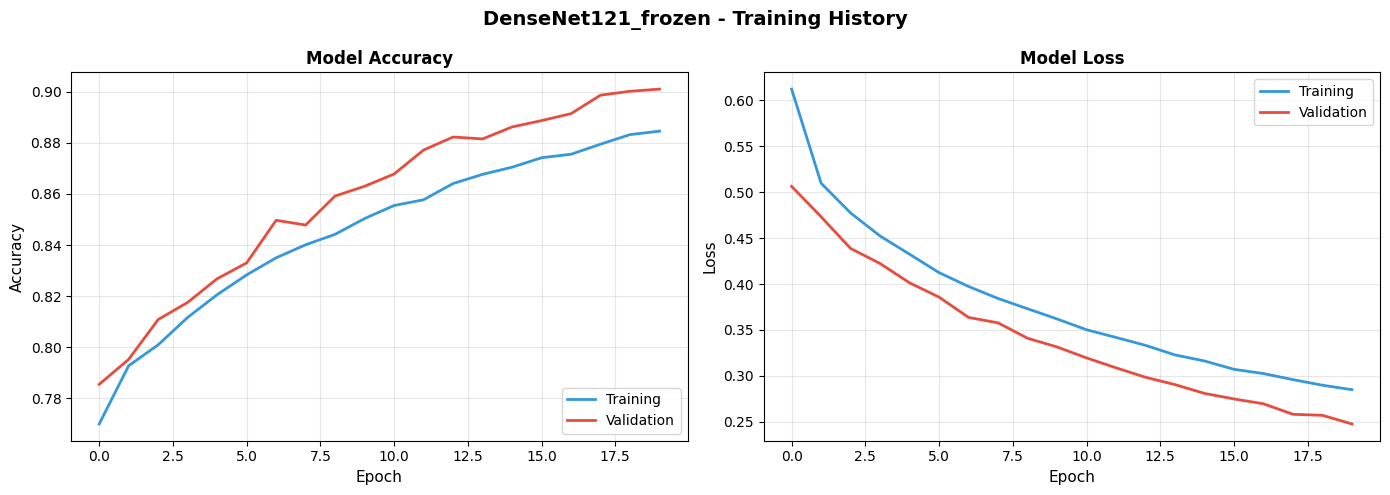

Plot saved: plots/densenet121_frozen_training.png

Final Results:
  Training Accuracy: 0.8845 (88.45%)
  Validation Accuracy: 0.9010 (90.10%)


In [ ]:
plot_training_history(history_densenet_frozen, MODEL_NAME, 'frozen')


Evaluating DenseNet121 (frozen)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.8986 - loss: 0.2596

DenseNet121_frozen - Test Results:
  Accuracy: 0.8991 (89.91%)
  Precision: 0.8943
  Recall: 0.8991
  F1-Score: 0.8928
  Cohen's Kappa: 0.6987
  Loss: 0.2538

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.7770    0.6620    0.7149      1000
 Moderate Dementia     0.8889    0.2449    0.3840        98
      Non Demented     0.9177    0.9749    0.9454     13445
Very mild Dementia     0.8231    0.6372    0.7183      2745

          accuracy                         0.8991     17288
         macro avg     0.8517    0.6297    0.6907     17288
      weighted avg     0.8943    0.8991    0.8928     17288



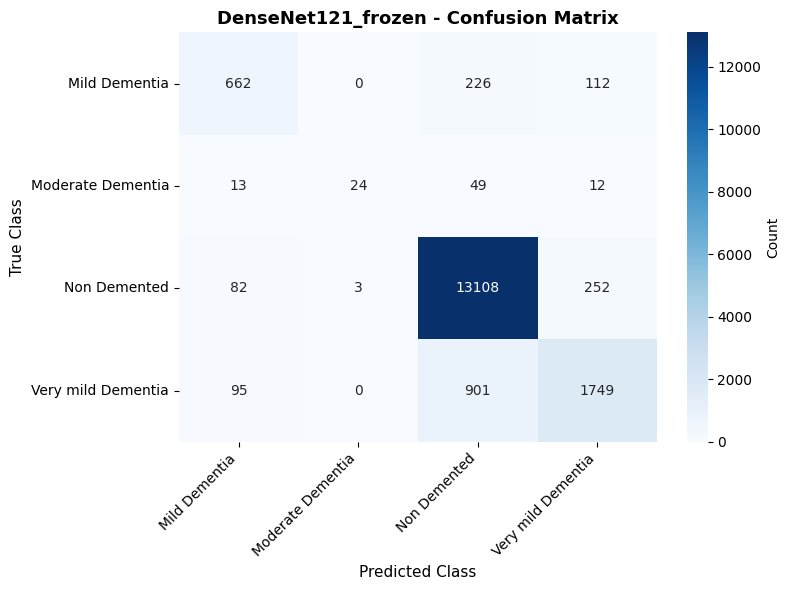


Plot saved: plots/densenet121_frozen_confusion.png

DenseNet121 (Frozen) Final Accuracy: 89.91%


In [ ]:
results_densenet_frozen = evaluate_transfer_model(
    model=densenet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Frozen) Final Accuracy: {results_densenet_frozen['accuracy']*100:.2f}%")

In [ ]:
MODEL_NAME = 'DenseNet121'

print(f"Training {MODEL_NAME} - Fine-tuned")

# Build model
densenet_finetuned = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='fine_tuned',
    fine_tune_layers=30,
    use_tuned_head=True
)

# Train
history_densenet_finetuned = train_transfer_model(
    model=densenet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=True
)

Training DenseNet121 - Fine-tuned

DenseNet121 Model Built:
  Mode: fine_tuned
  Top 30 layers trainable
  Learning rate: 0.0001
  Total parameters: 7,103,364
  Trainable: 707,268 (10.0%)
  Non-trainable: 6,396,096

Training DenseNet121 (fine_tuned)...
Epochs: 20
Class weights: Yes

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 229s 124ms/step - accuracy: 0.5446 - loss: 1.1446 - val_accuracy: 0.7936 - val_loss: 0.5422 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 168s 104ms/step - accuracy: 0.7943 - loss: 0.3910 - val_accuracy: 0.8830 - val_loss: 0.2873 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 168s 104ms/step - accuracy: 0.8880 - loss: 0.1900 - val_accuracy: 0.9113 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 167s 103ms/step - accuracy: 0.9391 - loss: 0.0989 - val_accuracy: 0.8911 - val_loss: 0.3127 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 168s 104ms/step - accuracy

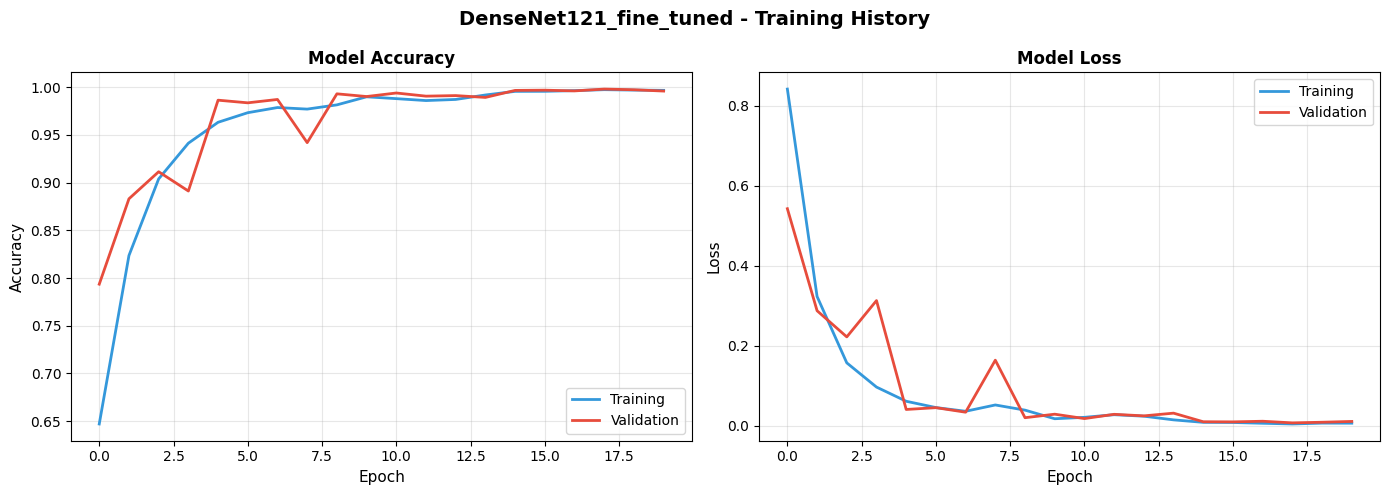

Plot saved: plots/densenet121_fine_tuned_training.png

Final Results:
  Training Accuracy: 0.9966 (99.66%)
  Validation Accuracy: 0.9958 (99.58%)


In [ ]:
plot_training_history(history_densenet_finetuned, MODEL_NAME, 'fine_tuned')


Evaluating DenseNet121 (fine_tuned)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.9979 - loss: 0.0068

DenseNet121_fine_tuned - Test Results:
  Accuracy: 0.9983 (99.83%)
  Precision: 0.9983
  Recall: 0.9983
  F1-Score: 0.9983
  Cohen's Kappa: 0.9953
  Loss: 0.0059

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     1.0000    0.9960    0.9980      1000
 Moderate Dementia     1.0000    1.0000    1.0000        98
      Non Demented     0.9986    0.9992    0.9989     13445
Very mild Dementia     0.9960    0.9945    0.9953      2745

          accuracy                         0.9983     17288
         macro avg     0.9986    0.9974    0.9980     17288
      weighted avg     0.9983    0.9983    0.9983     17288



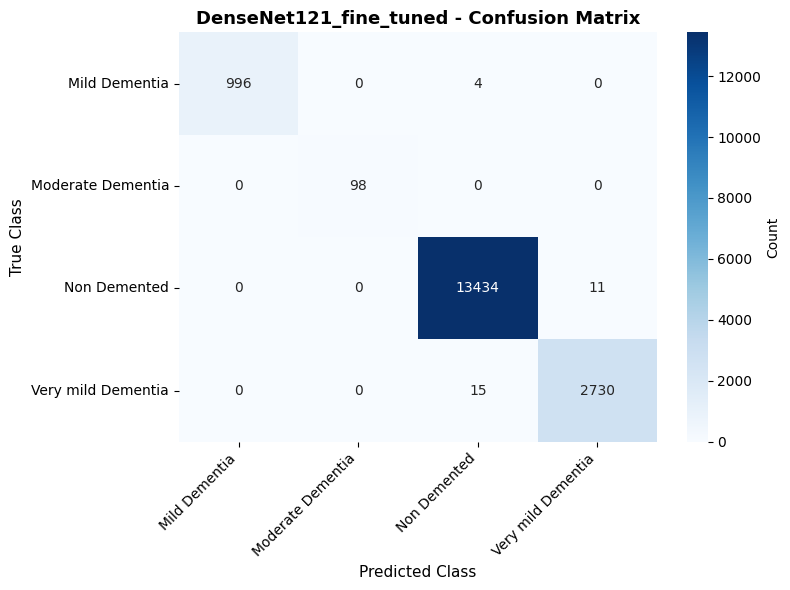


Plot saved: plots/densenet121_fine_tuned_confusion.png

DenseNet121 (Fine-tuned) Final Accuracy: 99.83%


In [ ]:
results_densenet_finetuned = evaluate_transfer_model(
    model=densenet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Fine-tuned) Final Accuracy: {results_densenet_finetuned['accuracy']*100:.2f}%")

In [ ]:
# EfficientNetB0 - Frozen Base
MODEL_NAME = 'EfficientNetB0'

print(f"Training {MODEL_NAME} - Frozen")

# Build model
efficientnet_frozen = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='frozen',
    use_tuned_head=True
)

# Train
history_efficientnet_frozen = train_transfer_model(
    model=efficientnet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=False
)



Training EfficientNetB0 - Frozen
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

EfficientNetB0 Model Built:
  Mode: frozen
  All layers frozen
  Learning rate: 0.0001
  Total parameters: 4,131,815.0
  Trainable: 82,244 (2.0%)
  Non-trainable: 4,049,571.0

Training EfficientNetB0 (frozen)...
Epochs: 20
Class weights: No

Epoch 1/20


2025-12-28 19:36:23.895452: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:36:24.038720: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:36:24.378033: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:36:24.518085: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:36:25.218574: E external/local_xla/xla/stream_

1619/1621 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7668 - loss: 0.6652

2025-12-28 19:37:30.660688: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:37:30.802130: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:37:31.125978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:37:31.265768: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:37:31.961795: E external/local_xla/xla/stream_

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7668 - loss: 0.6651

2025-12-28 19:38:05.367913: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:38:05.504092: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:38:05.805928: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:38:05.945794: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-28 19:38:06.623305: E external/local_xla/xla/stream_

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 123s 61ms/step - accuracy: 0.7668 - loss: 0.6651 - val_accuracy: 0.7851 - val_loss: 0.4921 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - accuracy: 0.7865 - loss: 0.5224 - val_accuracy: 0.8122 - val_loss: 0.4393 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 72s 44ms/step - accuracy: 0.8008 - loss: 0.4747 - val_accuracy: 0.8274 - val_loss: 0.4072 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.8126 - loss: 0.4494 - val_accuracy: 0.8391 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.8273 - loss: 0.4214 - val_accuracy: 0.8563 - val_loss: 0.3632 - learning_rate: 1.0000e-04
Epoch 6/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms/step - accuracy: 0.8335 - loss: 0.4080 - val_accuracy: 0.8666 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 7/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 74s 46ms

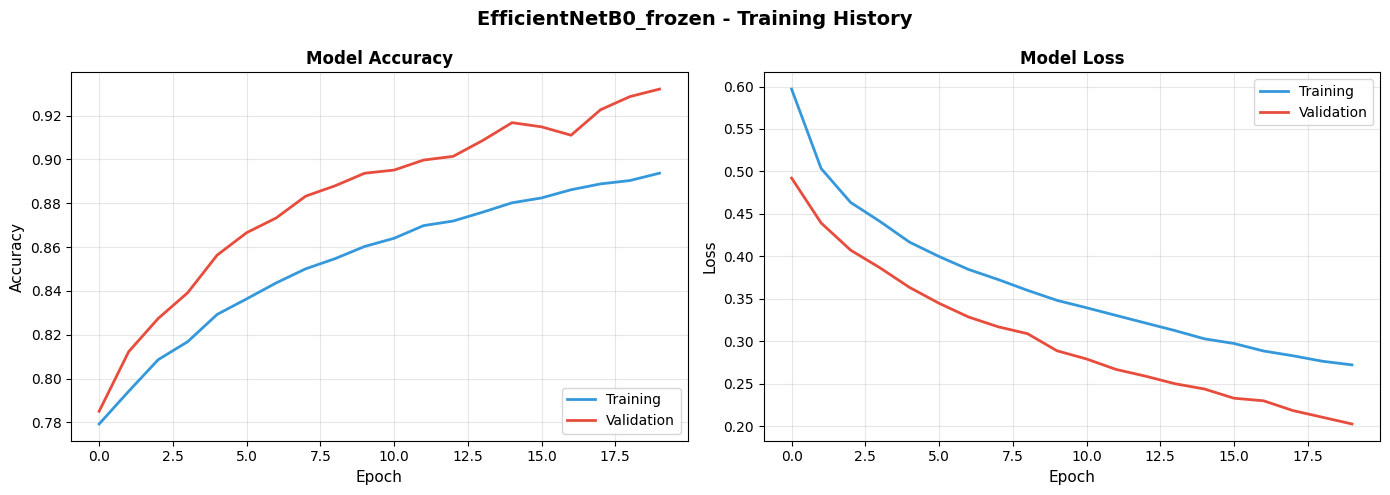

Plot saved: plots/efficientnetb0_frozen_training.png

Final Results:
  Training Accuracy: 0.8937 (89.37%)
  Validation Accuracy: 0.9321 (93.21%)


In [ ]:
# Plot
plot_training_history(history_efficientnet_frozen, MODEL_NAME, 'frozen')


Evaluating EfficientNetB0 (frozen)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9315 - loss: 0.2045

EfficientNetB0_frozen - Test Results:
  Accuracy: 0.9308 (93.08%)
  Precision: 0.9290
  Recall: 0.9308
  F1-Score: 0.9282
  Cohen's Kappa: 0.7993
  Loss: 0.2054

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.8843    0.7950    0.8373      1000
 Moderate Dementia     1.0000    0.6429    0.7826        98
      Non Demented     0.9415    0.9819    0.9613     13445
Very mild Dementia     0.8816    0.7403    0.8048      2745

          accuracy                         0.9308     17288
         macro avg     0.9268    0.7900    0.8465     17288
      weighted avg     0.9290    0.9308    0.9282     17288



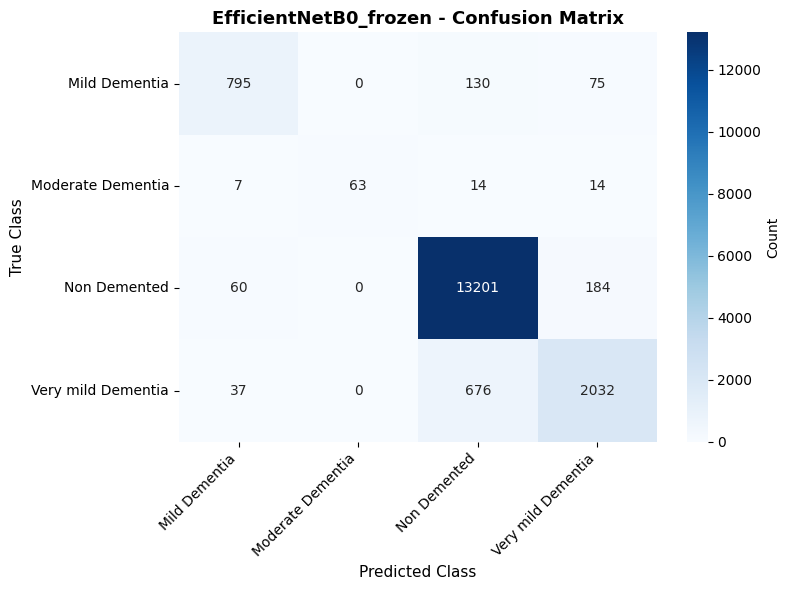


Plot saved: plots/efficientnetb0_frozen_confusion.png

EfficientNetB0 (Frozen) Final Accuracy: 93.08%


In [ ]:

# Evaluate
results_efficientnet_frozen = evaluate_transfer_model(
    model=efficientnet_frozen,
    model_name=MODEL_NAME,
    trainable_mode='frozen',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Frozen) Final Accuracy: {results_efficientnet_frozen['accuracy']*100:.2f}%")

In [ ]:
# EfficientNetB0 - Fine-tuned (Top 30 layers)
MODEL_NAME = 'EfficientNetB0'

print(f"Training {MODEL_NAME} - Fine-tuned")

# Build model
efficientnet_finetuned = build_transfer_model(
    model_name=MODEL_NAME,
    num_classes=4,
    trainable_mode='fine_tuned',
    fine_tune_layers=30,
    use_tuned_head=True
)

# Train
history_efficientnet_finetuned = train_transfer_model(
    model=efficientnet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    train_data=datasets[MODEL_NAME]['train'],
    val_data=datasets[MODEL_NAME]['val'],
    epochs=20,
    use_class_weights=True
)

Training EfficientNetB0 - Fine-tuned

EfficientNetB0 Model Built:
  Mode: fine_tuned
  Top 30 layers trainable
  Learning rate: 0.0001
  Total parameters: 4,131,815.0
  Trainable: 1,578,404 (38.2%)
  Non-trainable: 2,553,411.0

Training EfficientNetB0 (fine_tuned)...
Epochs: 20
Class weights: Yes

Epoch 1/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 136s 68ms/step - accuracy: 0.5605 - loss: 1.0348 - val_accuracy: 0.7466 - val_loss: 0.6336 - learning_rate: 1.0000e-04
Epoch 2/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 88s 54ms/step - accuracy: 0.7782 - loss: 0.4271 - val_accuracy: 0.8551 - val_loss: 0.3656 - learning_rate: 1.0000e-04
Epoch 3/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 87s 54ms/step - accuracy: 0.8439 - loss: 0.2638 - val_accuracy: 0.9014 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 4/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 87s 54ms/step - accuracy: 0.8821 - loss: 0.1894 - val_accuracy: 0.9412 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 5/20
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 88s 54ms/step - ac

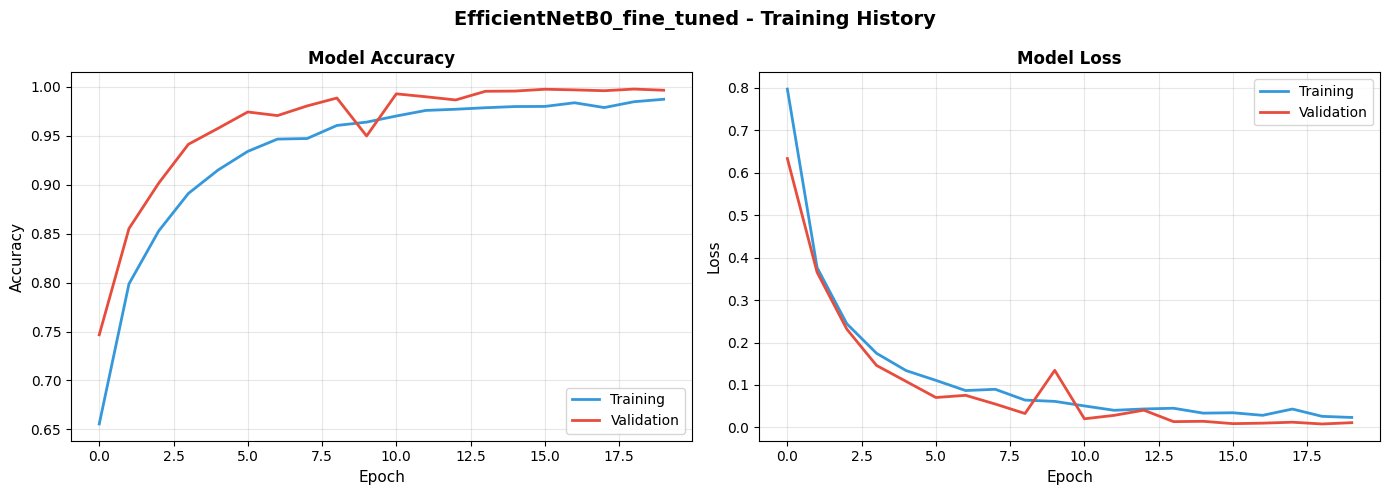

Plot saved: plots/efficientnetb0_fine_tuned_training.png

Final Results:
  Training Accuracy: 0.9872 (98.72%)
  Validation Accuracy: 0.9964 (99.64%)


In [ ]:
plot_training_history(history_efficientnet_finetuned, MODEL_NAME, 'fine_tuned')


Evaluating EfficientNetB0 (fine_tuned)...

541/541 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9981 - loss: 0.0071

EfficientNetB0_fine_tuned - Test Results:
  Accuracy: 0.9978 (99.78%)
  Precision: 0.9978
  Recall: 0.9978
  F1-Score: 0.9978
  Cohen's Kappa: 0.9940
  Loss: 0.0078

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9852    1.0000    0.9926      1000
 Moderate Dementia     0.9899    1.0000    0.9949        98
      Non Demented     0.9996    0.9975    0.9986     13445
Very mild Dementia     0.9938    0.9982    0.9960      2745

          accuracy                         0.9978     17288
         macro avg     0.9921    0.9989    0.9955     17288
      weighted avg     0.9978    0.9978    0.9978     17288



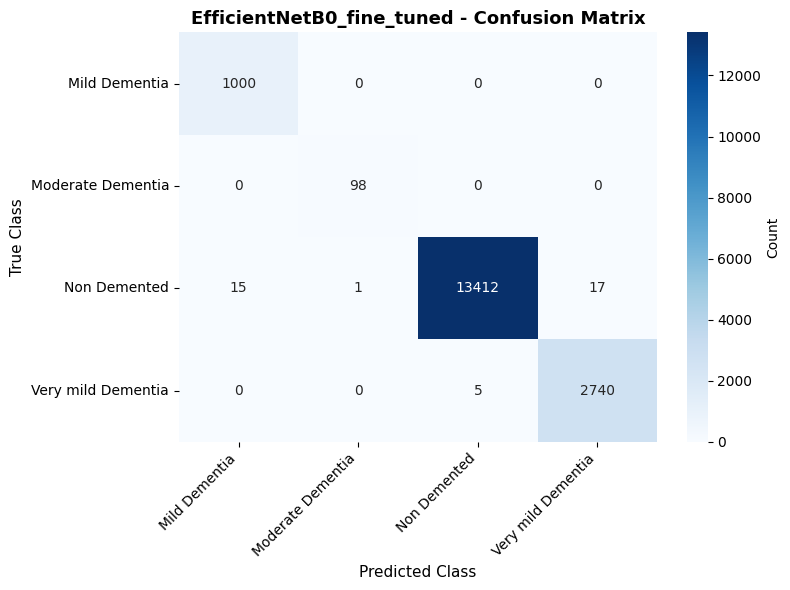


Plot saved: plots/efficientnetb0_fine_tuned_confusion.png

EfficientNetB0 (Fine-tuned) Final Accuracy: 99.78%


In [ ]:
# Evaluate
results_efficientnet_finetuned = evaluate_transfer_model(
    model=efficientnet_finetuned,
    model_name=MODEL_NAME,
    trainable_mode='fine_tuned',
    test_data=datasets[MODEL_NAME]['test'],
    y_true=y_test
)

print(f"\n{MODEL_NAME} (Fine-tuned) Final Accuracy: {results_efficientnet_finetuned['accuracy']*100:.2f}%")